In [1]:
import neurokit2 as nk
from scipy import signal, stats

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from scipy.signal import find_peaks, savgol_filter
from sklearn.metrics import adjusted_rand_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import neurokit2 as nk
from tqdm import tqdm
from math import atan, radians
import pandas as pd
import numpy as np
import umap
import h5py

import torch.optim as optim
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

import warnings
warnings.filterwarnings("ignore")

In [191]:
def ultra_filter(signals, n=None, channel=None):
    if n == None and channel==None:
        y = signals
    else:
        y = signals[n][channel]

    # 1. Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)
    peaks = peaks[peaks < len(y)]

    # 2. Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # 3. Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # 4. Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # 5. Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed

    return y_restored

def signal_transform_tensor_1(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i][0:max_len_signal]]) for signal in signals], (1, max_len_signal * len(signals)))
    # result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def signal_transform_tensor_1_non_fixed(signals, N=0, sampling_rate=500, scaler=None):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    res = []

    for signal in signals:
        if isinstance(scaler, type(None)):
            res.append(torch.tensor(ultra_filter([float(ss) for ss in signal[i]]), dtype=torch.float32))
        else:
            # torch.tensor(ultra_filter([float(ss) for ss in signal[i]]), dtype=torch.float32)
            res.append(torch.tensor(scaler.transform(torch.reshape(torch.tensor(ultra_filter([float(ss) for ss in signal[i]]), dtype=torch.float32), (-1, 1)))).flatten())
    
    return res

    # result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i]]) for signal in signals], (1, max_len_signal * len(signals)))
    # # result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    # return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

def ecg_quality_metrics(signal, fs=1000):
    # Очистка сигнала
    cleaned = nk.ecg_clean(signal, sampling_rate=fs)
    
    # Детекция R-пиков
    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs)['ECG_R_Peaks']
    
    # Расчет SNR
    noise = signal - cleaned
    snr = 10 * np.log10(np.var(cleaned) / np.var(noise))
    
    # Стабильность RR-интервалов
    rr = np.diff(r_peaks) / fs * 1000  # в мс
    cv_rr = (np.std(rr) / np.mean(rr)) * 100  # Коэффициент вариации
    
    # return {"SNR_dB": snr, "RR_CV%": cv_rr}
    return snr, cv_rr

def ecg_quality_metrics_ultra(signal, fs=1000):
    # Очистка сигнала
    cleaned = ultra_filter(signal)
    
    # Детекция R-пиков
    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs)['ECG_R_Peaks']
    
    # Расчет SNR
    noise = signal - cleaned
    snr = 10 * np.log10(np.var(cleaned) / np.var(noise))
    
    # Стабильность RR-интервалов
    rr = np.diff(r_peaks) / fs * 1000  # в мс
    cv_rr = (np.std(rr) / np.mean(rr)) * 100  # Коэффициент вариации
    
    # return {"SNR_dB": snr, "RR_CV%": cv_rr}
    return snr, cv_rr

def load_data(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def load_data_age_sex(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    metadata['Sex'].replace({'M': 0, 'F': 1}, inplace=True)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
        ages = health_metadata['Age'].values
        sexs = health_metadata['Sex'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values
        ages = metadata['Age'].values
        sexs = metadata['Sex'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels, ages, sexs

def delete_bad_snr_db(signals_, labels_, channel_check=0, print_idx=False):
    signals = []
    labels = []
    deleted_idx = []
    ok_idx = []
    
    for i in range(len(signals_)):
        sbr_db, rr = ecg_quality_metrics_ultra(signals_[i][channel_check], 500)
        
        if sbr_db >= 15:
            signals.append(signals_[i])
            labels.append(labels_[i])
            ok_idx.append(i)
        else:
            deleted_idx.append(i)
    
    if print_idx:
        print("deleted indexes:")
        print(*deleted_idx)
    
    print(f"num of left: {len(signals)}")
    
    return signals, labels, ok_idx

def delete_bad_snr_db_ages_sexs(signals_, labels_, ages_=None, sexs_=None, channel_check=0, print_idx=False):
    signals = []
    labels = []
    ages = []
    sexs = []
    deleted_idx = []
    
    for i in range(len(signals_)):
        sbr_db, rr = ecg_quality_metrics_ultra(signals_[i][channel_check], 500)
        
        if sbr_db >= 15:
            signals.append(signals_[i])
            labels.append(labels_[i])
            ages.append(ages_[i])
            sexs.append(sexs_[i])
        else:
            deleted_idx.append(i)
    
    if print_idx:
        print("deleted indexes:")
        print(*deleted_idx)
    
    print(f"num of left: {len(signals)}")
    
    return signals, labels, ages, sexs

def load_markers(npz_path):
    """
    Загружает разметку из NPZ-файла
    Возвращает словарь с:
    - 'files': список имен файлов
    - 'markers': список словарей с маркерами для каждого файла
    - 'sample_rate': частота дискретизации
    """
    data = np.load(npz_path, allow_pickle=True)
    
    result = {
        'files': list(data['files']),
        'markers': list(data['markers']),
        'sample_rate': int(data.get('sample_rate', 500))  # По умолчанию 500 Гц
    }
    
    return result

def find_local_maxima_above_threshold(arr, threshold, sample_freq=500):
    n = len(arr)
    maxima_indices = []

    delta = 4
    
    for i in range(n):
        is_max = False
        if n == 0:
            return []
        if n == 1:
            is_max = True
        elif i == 0:
            is_max = arr[i] > arr[i+1]
        elif i == n - 1:
            is_max = arr[i] > arr[i-1]
        else:
            is_max = arr[i] > arr[i-1] and arr[i] > arr[i+1]
        
        if is_max and arr[i] > threshold and i < len(arr) - 1 - delta:
            maxima_indices.append(i)
    
    maxima_indices_angle = []
    angle = radians(85)
    angle_max = radians(90)

    for index in maxima_indices:
        if angle < atan((abs(arr[index] - arr[index - delta]))*sample_freq/delta) < angle_max and angle < atan((abs(arr[index + delta] - arr[index]))*sample_freq/delta) < angle_max:
            maxima_indices_angle.append(index)

    return maxima_indices_angle

def split_into_windows_into(data, labels_, scaler=None, shift=0, auto_dop=0):
    windows = []

    if isinstance(scaler, type(None)):
        scaler = StandardScaler()
        scaler.n_features_in_ = 1
        scaler.feature_names_in_ = 1
        scaler.mean_ = np.array([0])
        scaler.var_ = np.array([1])
        scaler.scale_ = np.array([1])

    labels_ = labels_.flatten()

    labels = []
    r_peaks_all = []
    
    for i in range(len(data)):
        r_reaks = find_local_maxima_above_threshold(data[i], (max(data[i]) - min(data[i]))*0.5 + min(data[i]))
        r_peaks_all.append(r_reaks)
        
        for j in range(len(r_reaks) - 1):
            if r_reaks[j] != r_reaks[j + 1]:
                res = scaler.transform(data[i][r_reaks[j] - shift:r_reaks[j + 1] - shift].reshape(-1, 1)).reshape(-1).tolist()
                for g in range(len(res), auto_dop):
                    res.append(res[-1])
                windows.append(res)
                labels.append(labels_[i])

    result = []
    for i in range(len(windows)):
        # print(torch.tensor(windows[i]).reshape((1, len(windows[i]), 1)).shape)
        result.append(torch.tensor(windows[i]).reshape((1, len(windows[i]), 1)))

    return result, labels, r_peaks_all

def find_R_peaks(data):
    r_peaks_all = []

    for i in range(len(data)):
        r_reaks = find_local_maxima_above_threshold(data[i], (max(data[i]) - min(data[i]))*0.5 + min(data[i]))
        r_peaks_all.append(r_reaks)
    
    return r_peaks_all

def visualize_channel_with_peaks(signal, peaks, index=0, channel=0):
    ecg_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    plt.rcParams['figure.figsize'] = [14, 4]

    plt.title(ecg_order[channel])
    plt.plot(signal[index])
    plt.title((f'Отведение {ecg_order}'))

    for peak in peaks[index]:
        plt.axvline(peak, color='red', alpha=0.2)

    plt.show()

In [ ]:
signals, labels = load_data('../csv/metadata.csv', 0, 1000, True)
signals, labels, ok_idx = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_1_non_fixed(signals)

from itertools import chain

flat_list = list(chain(*signals_transformed))

scale_ = np.std(flat_list)
mean_ = np.mean(flat_list)

print("mean: ", mean_)
print("std: ", scale_)
print("var: ", scale_*scale_)

scaler = StandardScaler()
# scaler.fit([flat_list])
scaler.n_features_in_ = 1
scaler.feature_names_in_ = 1
scaler.mean_ = np.array([mean_])
scaler.var_ = np.array([scale_*scale_])
scaler.scale_ = np.array([scale_])

Data loaded successfully.
          Health    number:     515
          Diseased  number:     0


num of left: 382
mean:  0.0002348341
std:  0.09816028
var:  0.009635441


StandardScaler()

In [159]:
signals, labels = load_data('../csv/metadata.csv', 0, 400, False)
signals, labels, ok_idx = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_1_non_fixed(signals, scaler=scaler)
labels_transformed = label_transform_tensor(labels)

# signals_transformed_windowed, labels_transformed_windowed, r_peaks_all = split_into_windows_into(signals_transformed, labels_transformed)

Data loaded successfully.
          Health    number:     206
          Diseased  number:     194


num of left: 295
Label transformed to tensor successfully



In [160]:
data_file = pd.read_csv('../csv/metadata.csv')

In [161]:
idx_code = []

for i in range(len(ok_idx)):
    idx_code.append(data_file.iloc[ok_idx[i]]['AHA_Code'])

In [162]:
for idx, i, r_peaks in zip(range(len(idx_code)), idx_code, r_peaks_all):
    print(idx, i, r_peaks)

0 1 [205, 634, 1054, 1468, 1865, 2274, 2688, 3109, 3520, 3945, 4388, 4830, 5260, 5702]
1 146 [136, 539, 949, 1364, 1761, 2154, 2568, 2997, 3400, 3794, 4209, 4634, 5038, 5446]
2 106 [260, 638, 994, 1368, 1721, 2091, 2446, 2815, 3171, 3532, 3890, 4251, 4607, 4966, 5324, 5678, 6025, 6368]
3 1 [117, 556, 1022, 1477, 1942, 2432, 2831, 3348, 3809, 4226, 4667]
4 1 [127, 445, 767, 1096, 1429, 1754, 2071, 2395, 2724, 3042, 3358, 3685, 4014, 4333, 4652, 4971, 5295, 5619, 5939]
5 1 [529, 1064, 1594, 2122, 2650, 3163, 3663, 4183, 4722, 5235, 5756, 6256, 6755, 7265]
6 22;23 [436, 947, 1471, 1999, 2477, 2969, 3437, 3895, 4379, 4842]
7 1 [198, 652, 1095, 1531, 1965, 2385, 2798, 3213, 3633, 4071, 4512, 4952, 5408, 5865]
8 30+310 [61, 304, 545, 1050, 1334, 1974, 2419, 2717, 3229, 3539, 4011, 4257, 4496, 4730, 4994]
9 1 [9, 389, 755, 1118, 1495, 1880, 2253, 2632, 3022, 3406, 3782, 4170, 4565, 4947]
10 22;147 [75, 633, 1183, 1715, 2266, 2795, 3328, 3881, 4410, 4951]
11 1 [76, 440, 821, 1222, 1623, 2390, 

In [ ]:
r_peaks_all = find_R_peaks(signals_transformed)

In [164]:
r_peaks_all_delta = []
means = []
stds = []
vars = []

for r_peaks in r_peaks_all:
    r_peaks_delta = []
    for j in range(len(r_peaks) - 1):
        r_peaks_delta.append(r_peaks[j + 1] - r_peaks[j])
    r_peaks_all_delta.append(r_peaks_delta)
    
    means.append(np.mean(r_peaks_delta))
    stds.append(np.std(r_peaks_delta))
    vars.append(np.var(r_peaks_delta))

0 1 422.84615384615387 13.592113968407473 184.74556213017752


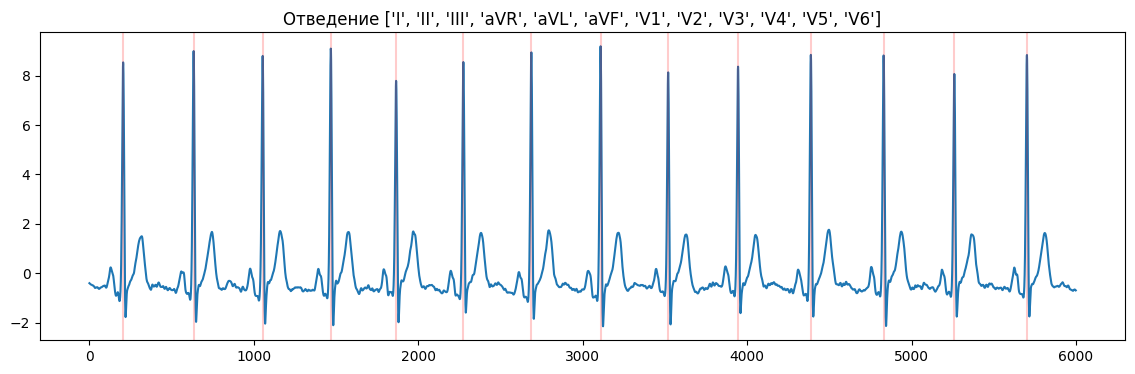

1 146 408.46153846153845 10.645442395080735 113.32544378698228


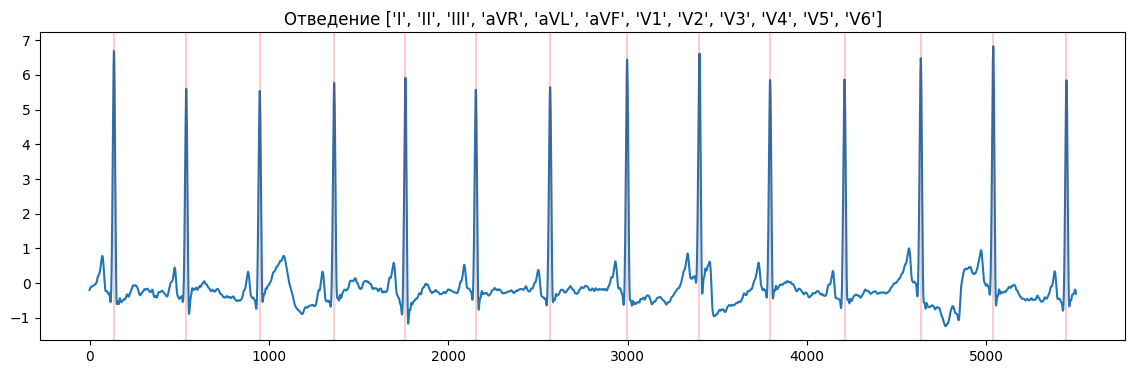

2 106 359.29411764705884 8.810185989105438 77.61937716262976


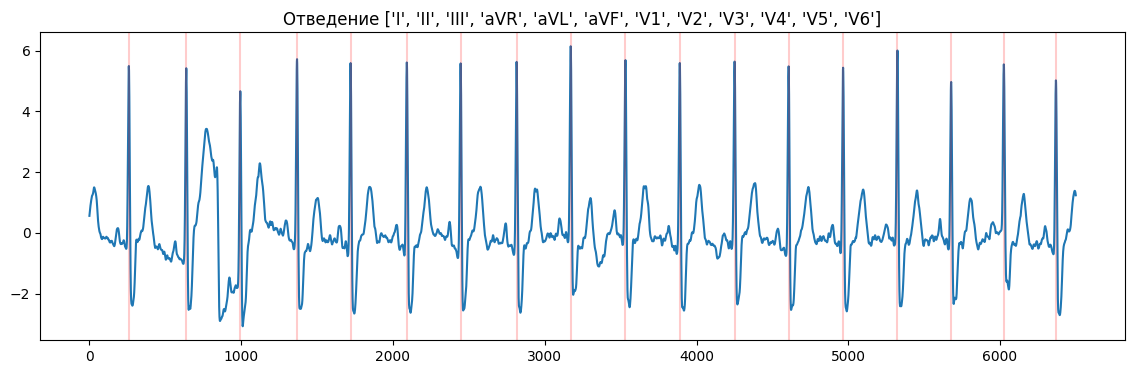

3 1 455.0 32.18384688007324 1035.8


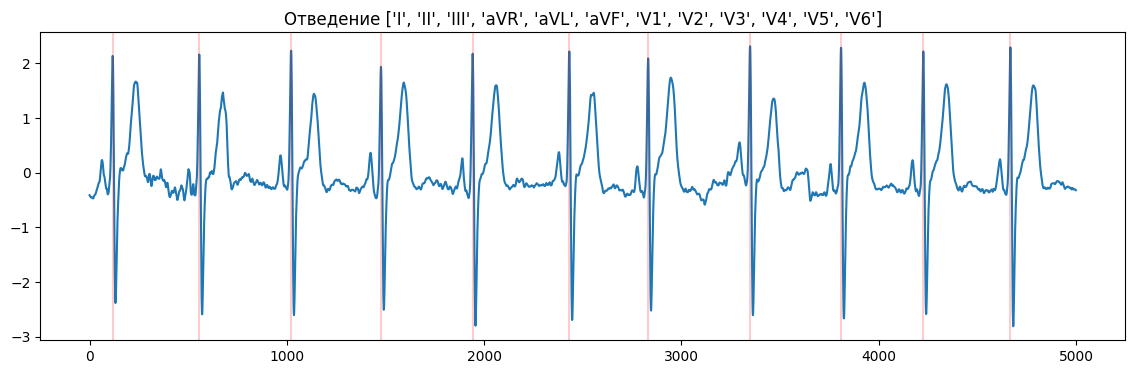

4 1 322.8888888888889 4.852134569088456 23.543209876543212


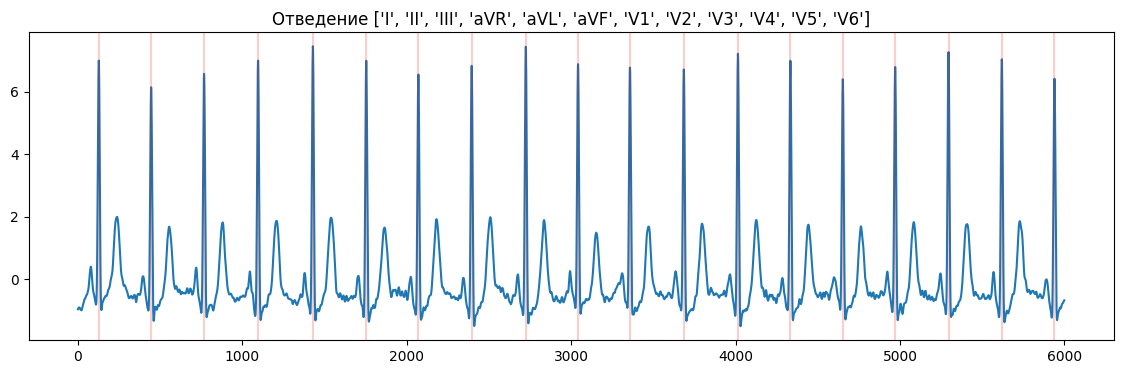

5 1 518.1538461538462 13.03749712793628 169.97633136094674


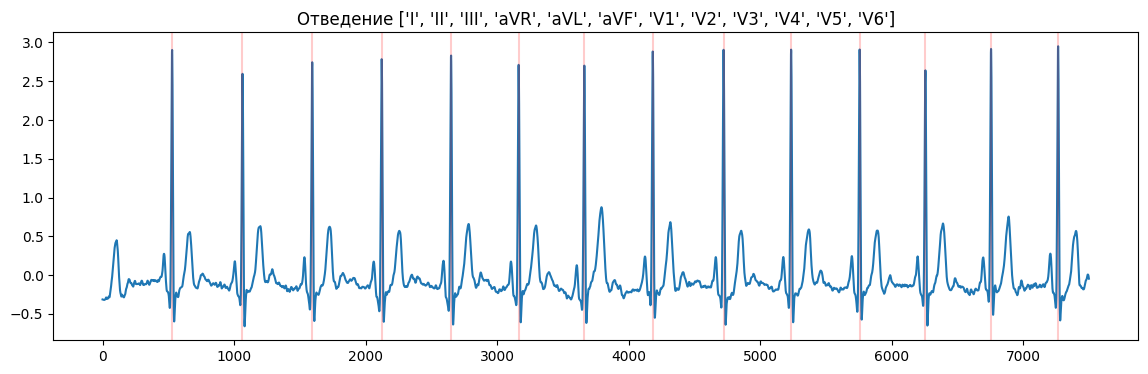

6 22;23 489.55555555555554 24.63110549741305 606.6913580246913


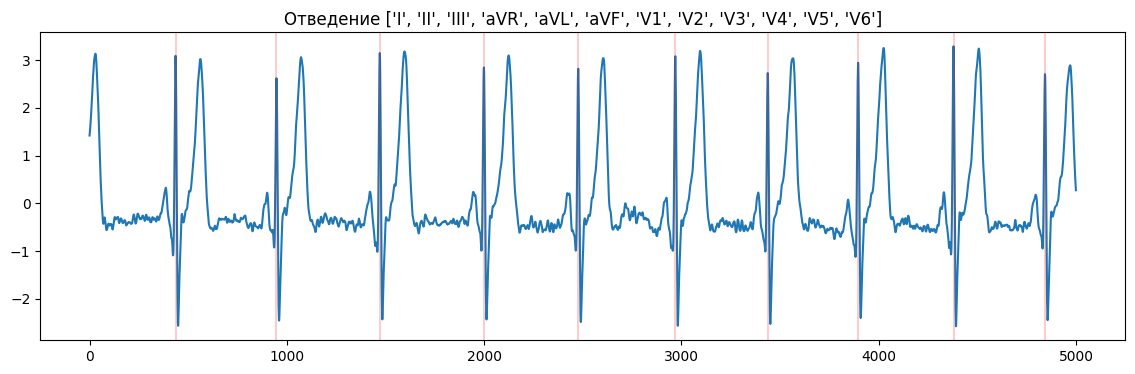

7 1 435.9230769230769 14.53093008014569 211.14792899408283


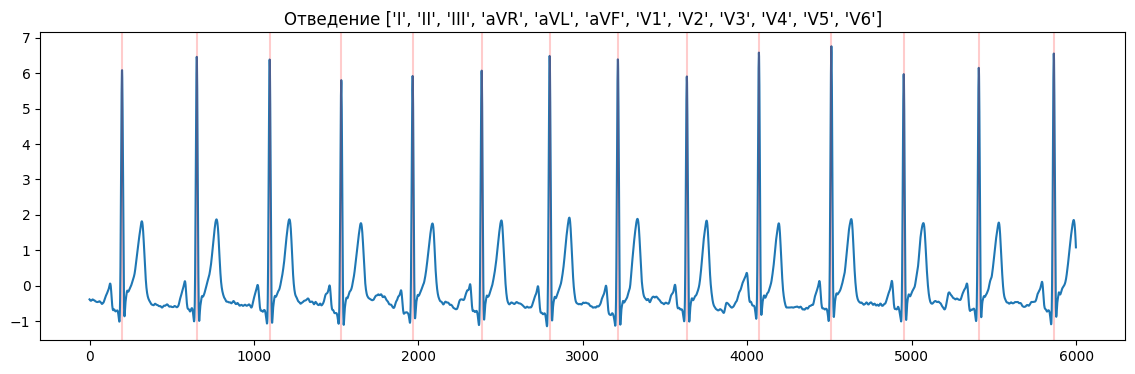

8 30+310 352.35714285714283 129.33323909457258 16727.08673469388


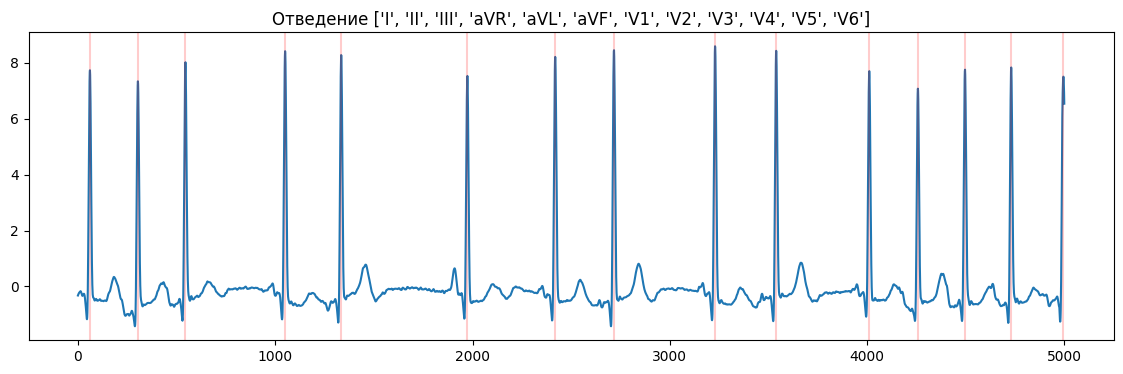

9 1 379.84615384615387 8.742875374983061 76.4378698224852


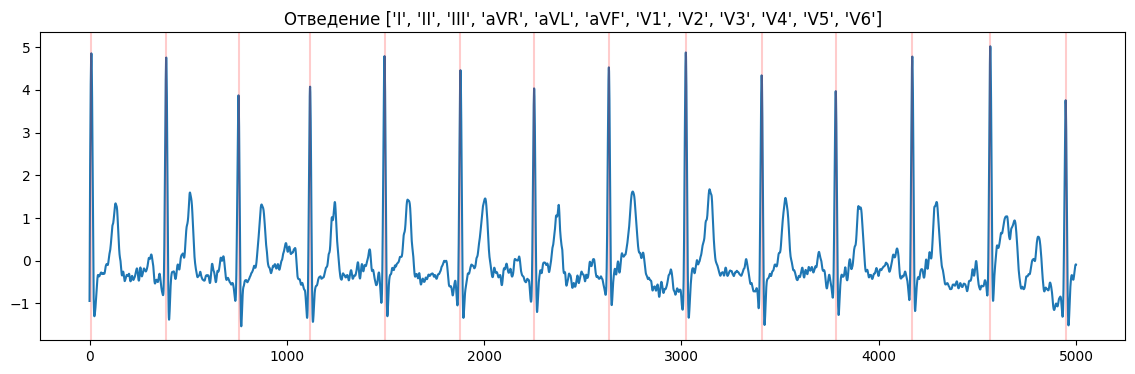

10 22;147 541.7777777777778 10.75771328218634 115.7283950617284


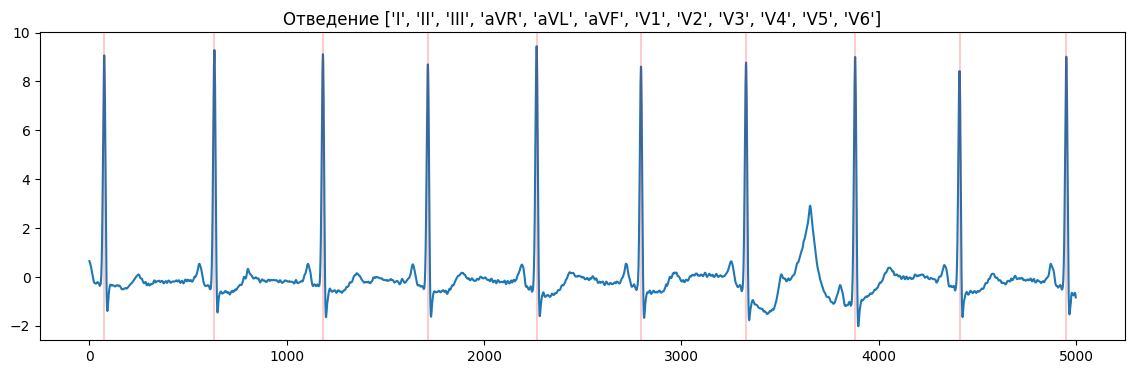

11 1 432.27272727272725 107.5352719378335 11563.834710743802


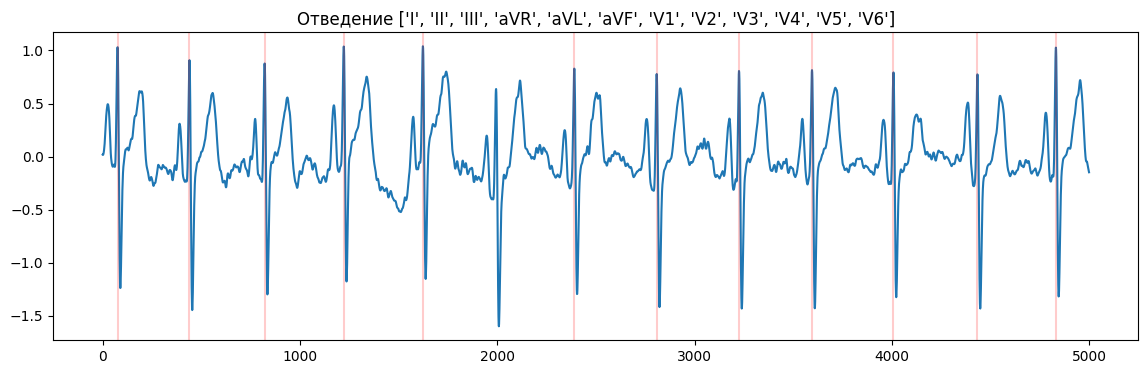

12 60 315.93333333333334 50.47305111531191 2547.528888888889


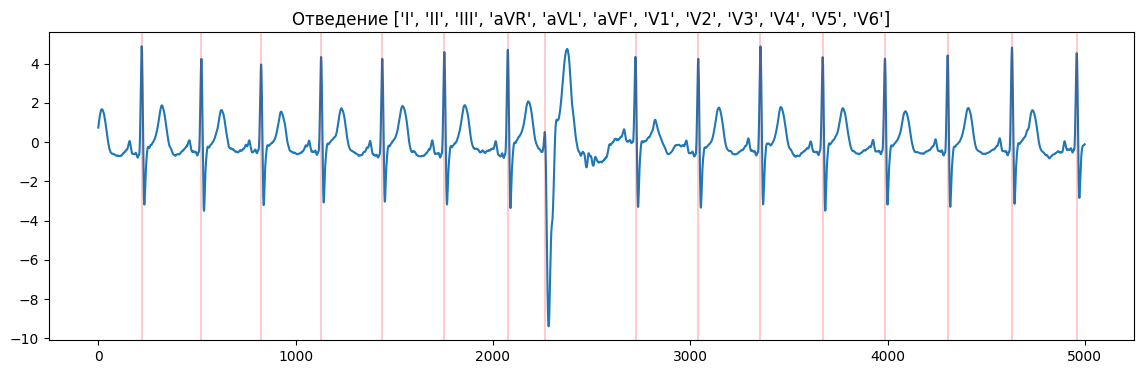

13 30 377.6666666666667 65.19756300830747 4250.722222222222


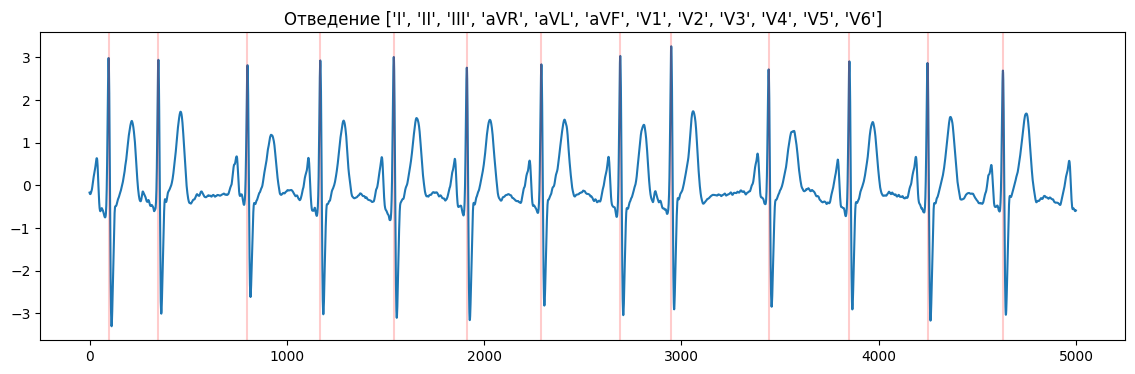

14 1 475.3 15.741982086128798 247.81


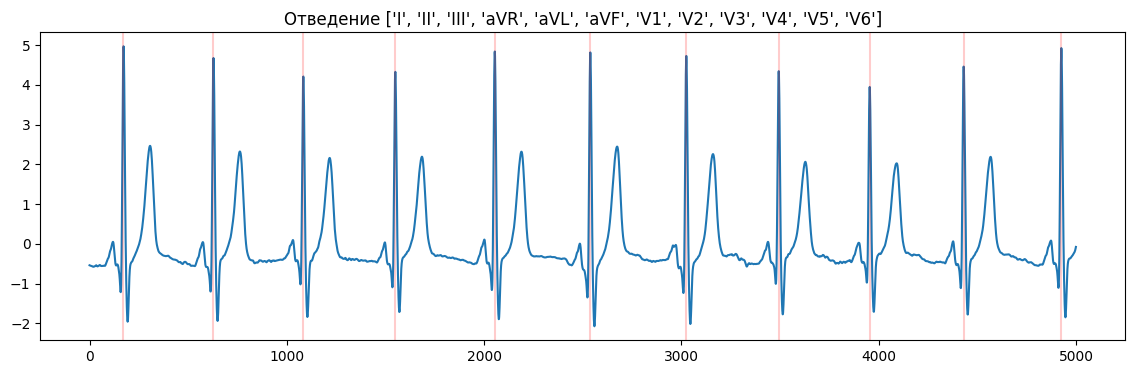

15 125;82 498.22222222222223 4.540625942600567 20.617283950617285


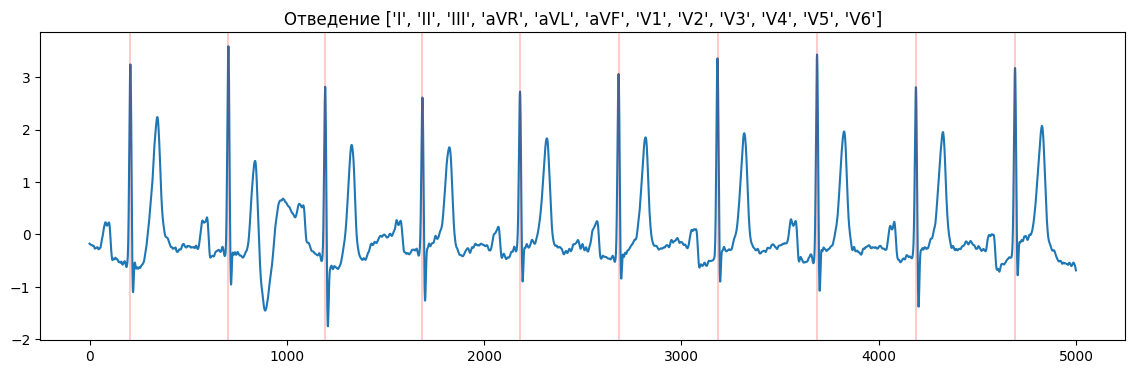

16 105 433.54545454545456 15.089813760906493 227.70247933884295


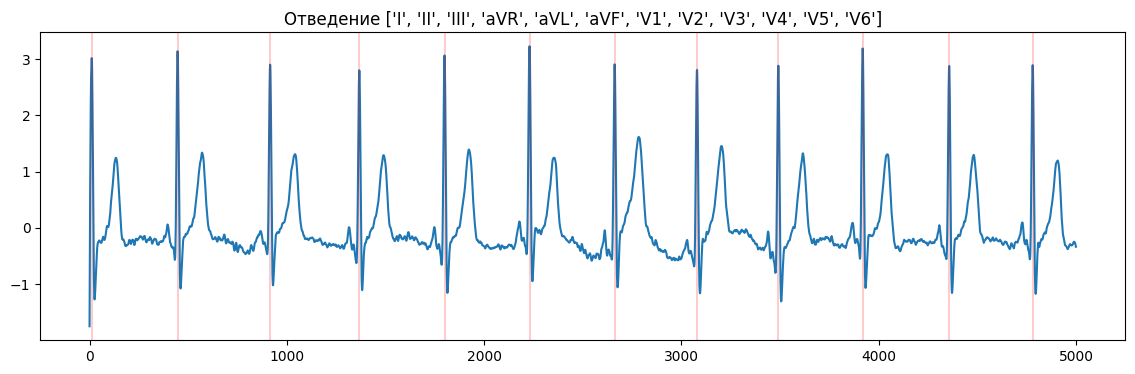

17 1 349.9230769230769 3.384615384615384 11.455621301775146


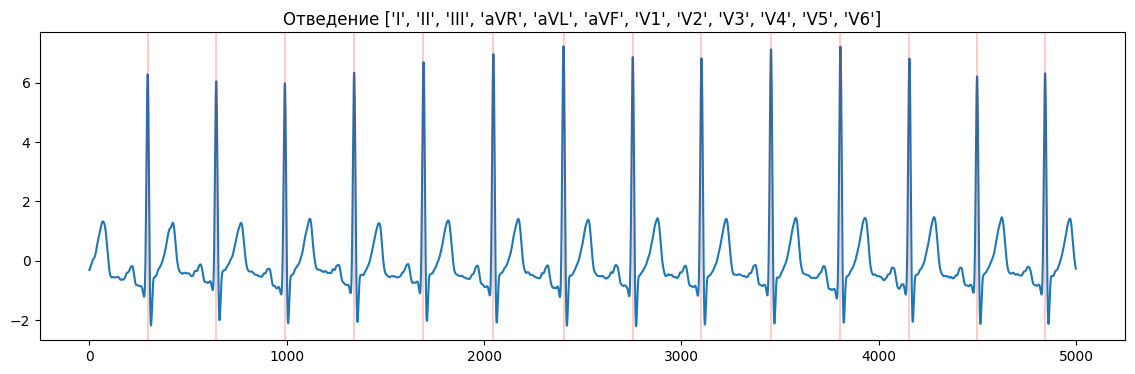

18 1 437.8181818181818 11.043864457188903 121.96694214876032


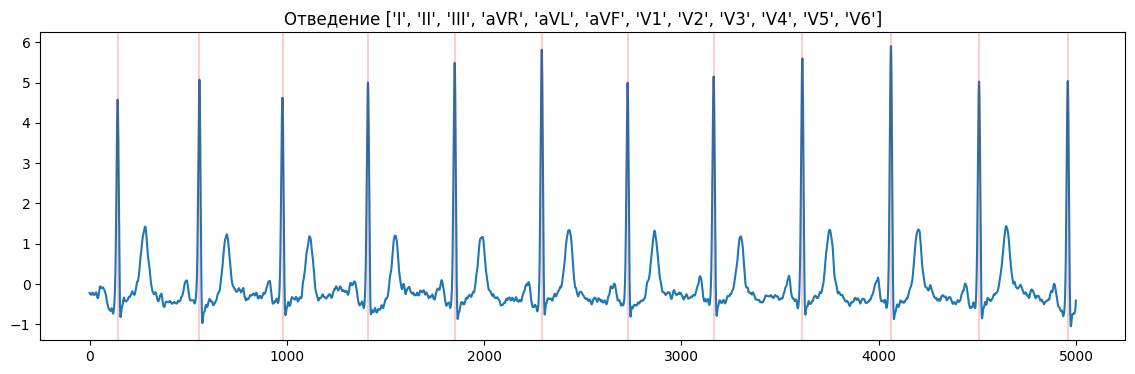

19 1 497.8888888888889 19.034731089624593 362.320987654321


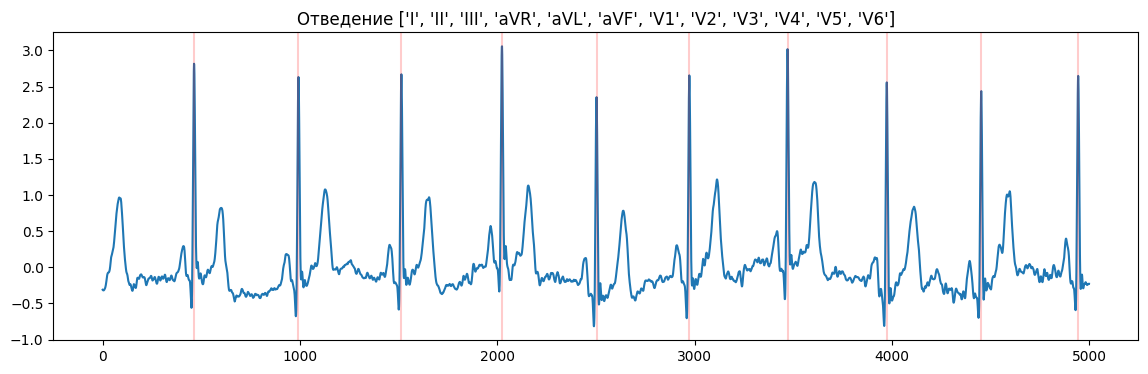

20 1 394.75 13.589977924926883 184.6875


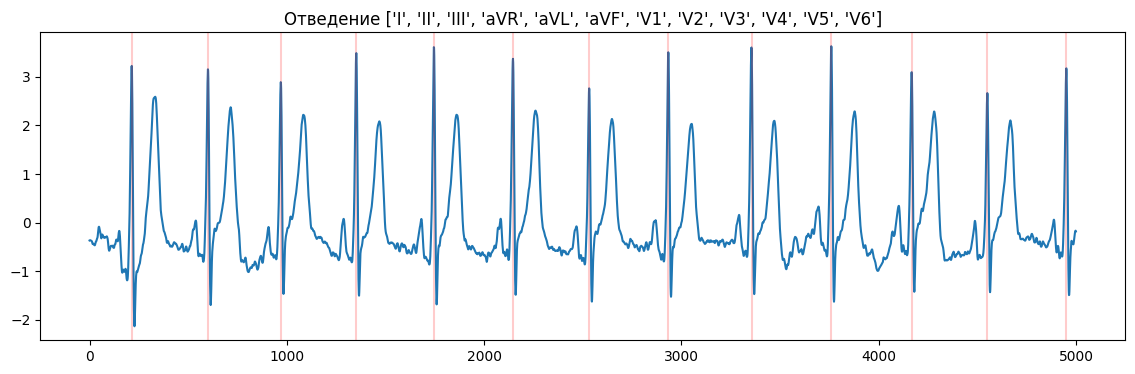

21 1 407.09090909090907 20.2908602149949 411.71900826446284


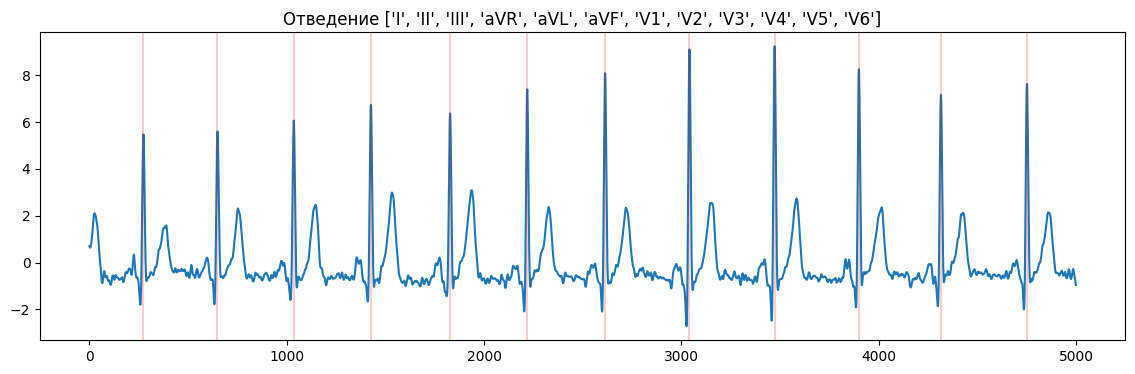

22 105 409.3636363636364 21.406340298114426 458.2314049586776


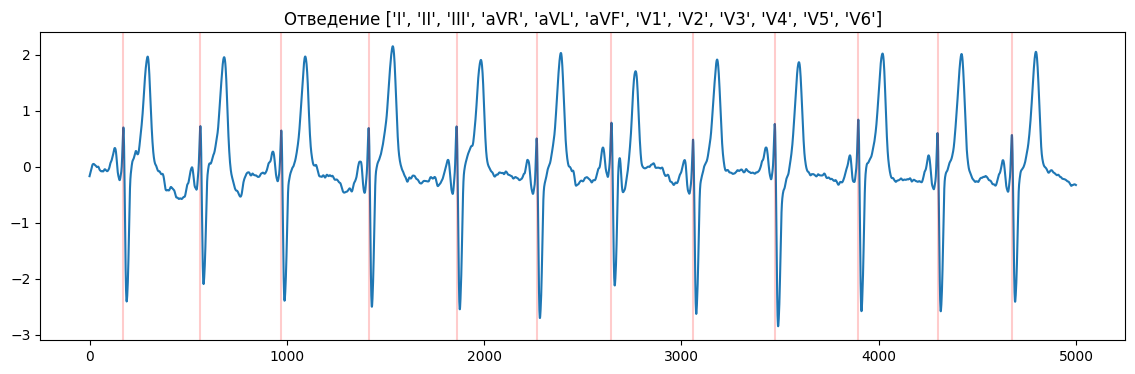

23 22 503.0 11.953614051360738 142.88888888888889


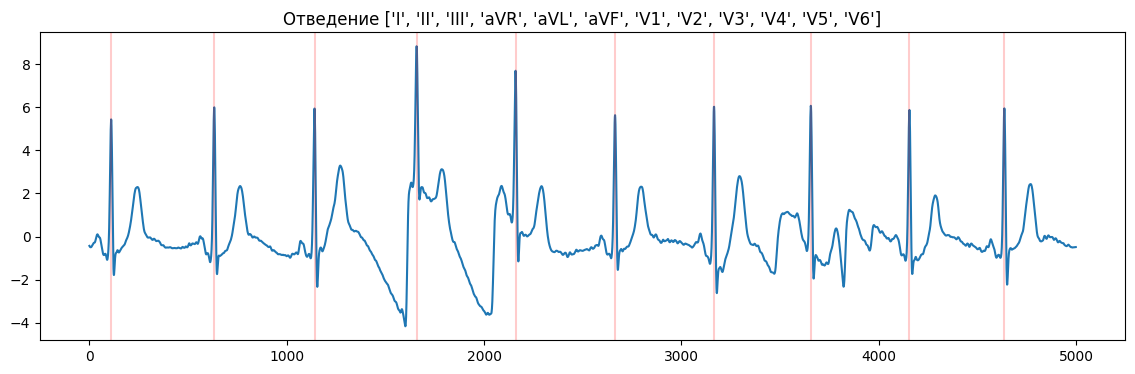

24 1 443.0 4.857983120596447 23.6


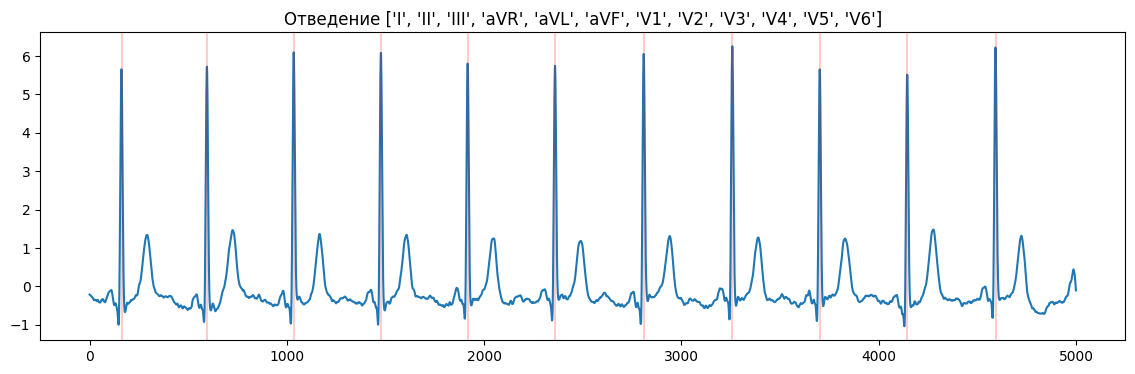

25 1 421.3636363636364 10.27152044399489 105.50413223140498


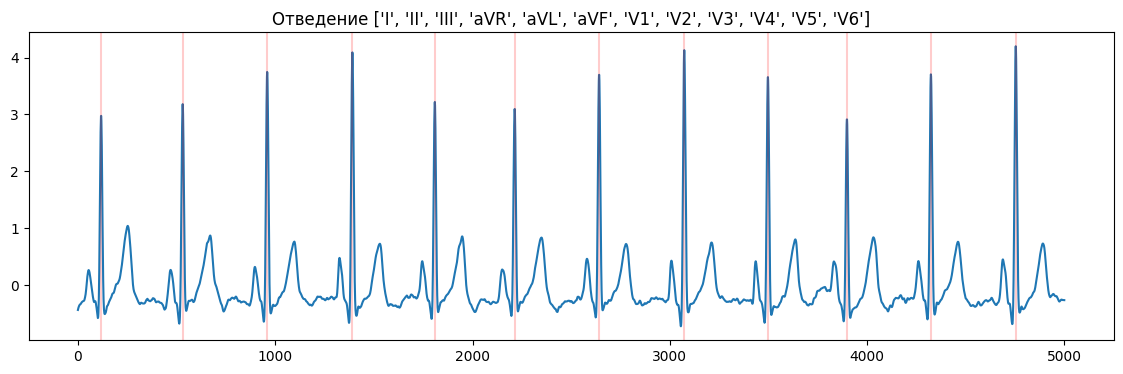

26 60+310 575.0 205.9579245056297 42418.666666666664


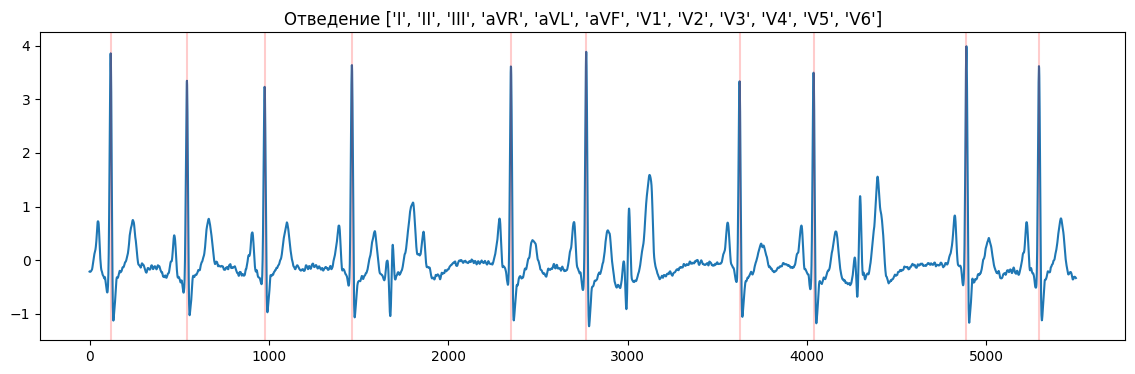

27 23 442.5 26.97498841519677 727.65


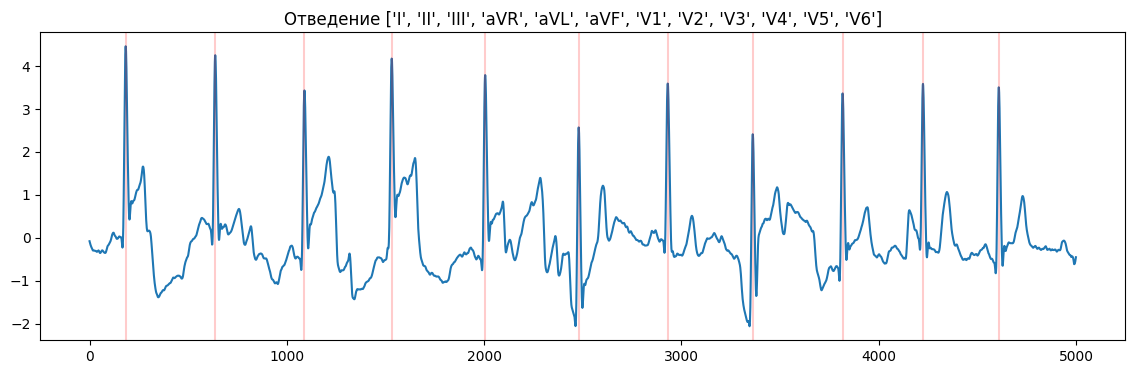

28 1 376.0 16.153113536500538 260.9230769230769


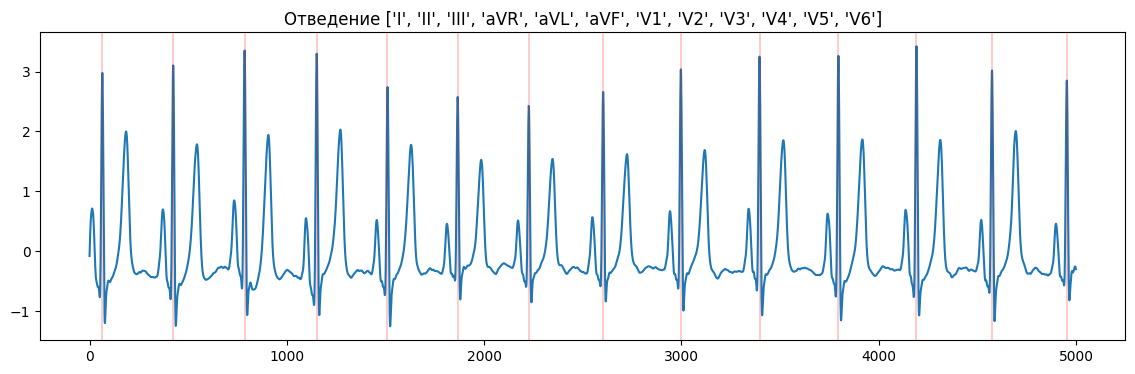

29 22 652.7857142857143 19.939832967593038 397.59693877551024


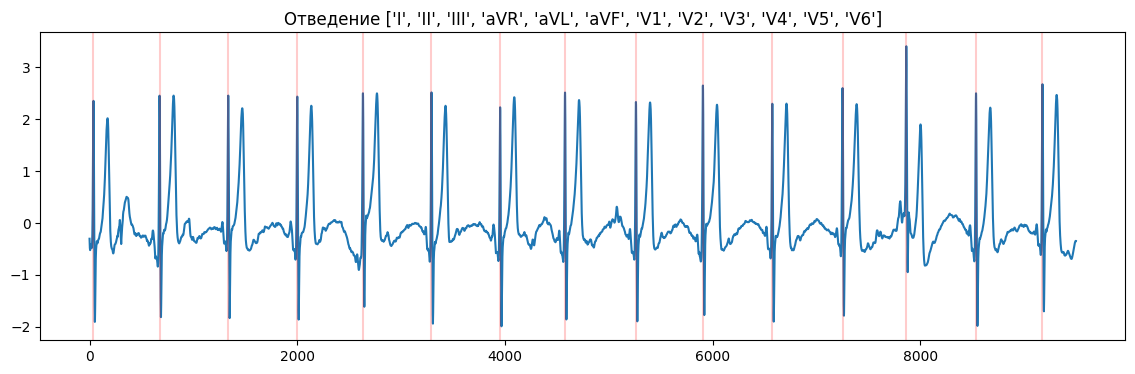

30 1 452.1111111111111 11.239260992357147 126.32098765432099


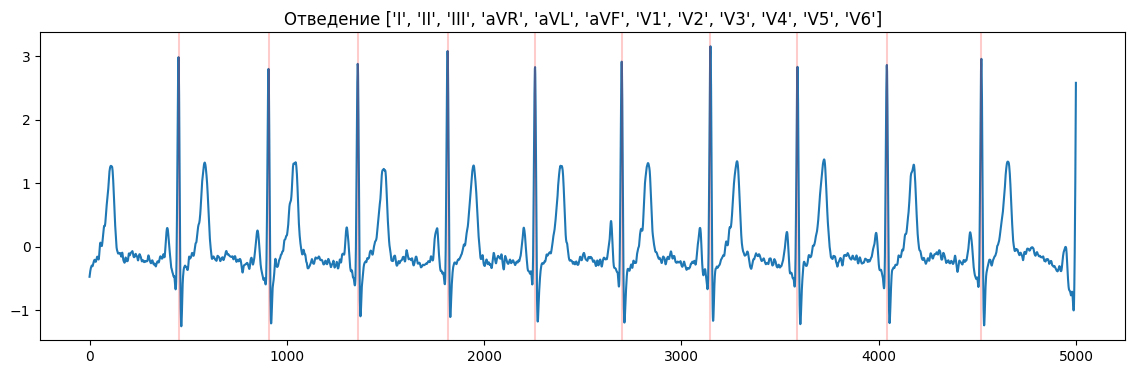

31 1 415.09090909090907 18.942278568202187 358.80991735537197


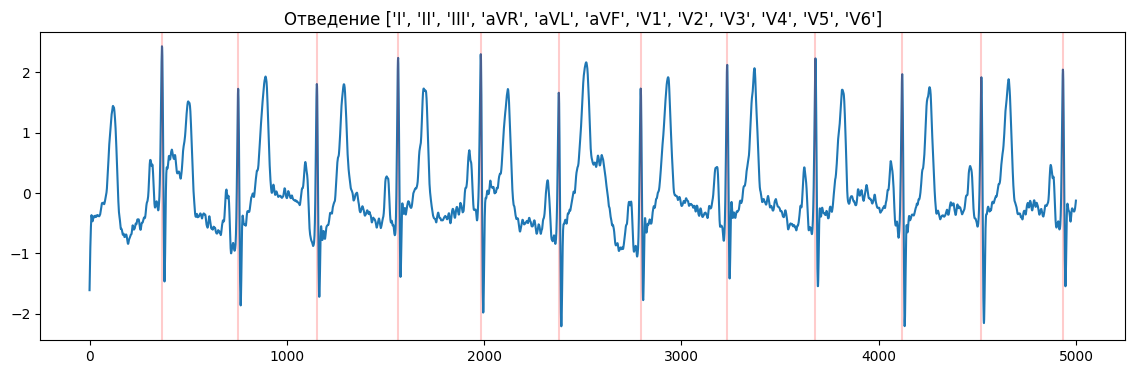

32 1 408.1818181818182 4.38630475702357 19.2396694214876


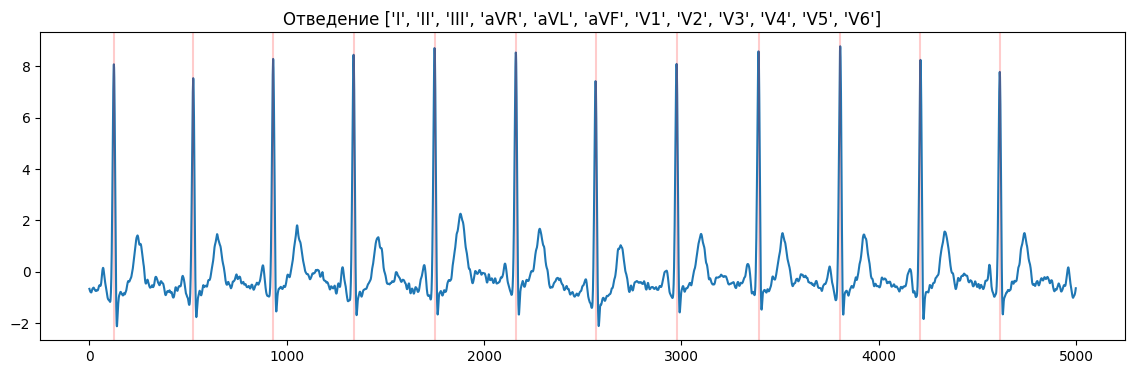

33 1 430.2 10.97087052152198 120.35999999999999


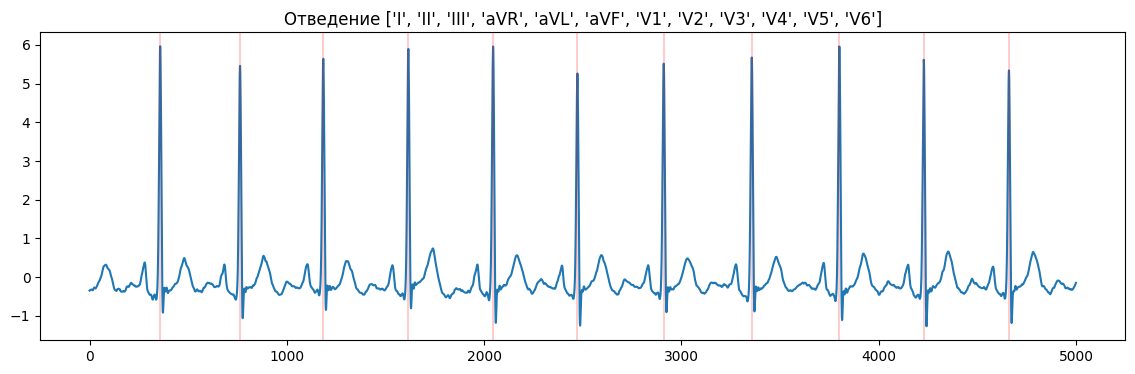

34 1 388.5833333333333 19.220034397009343 369.40972222222223


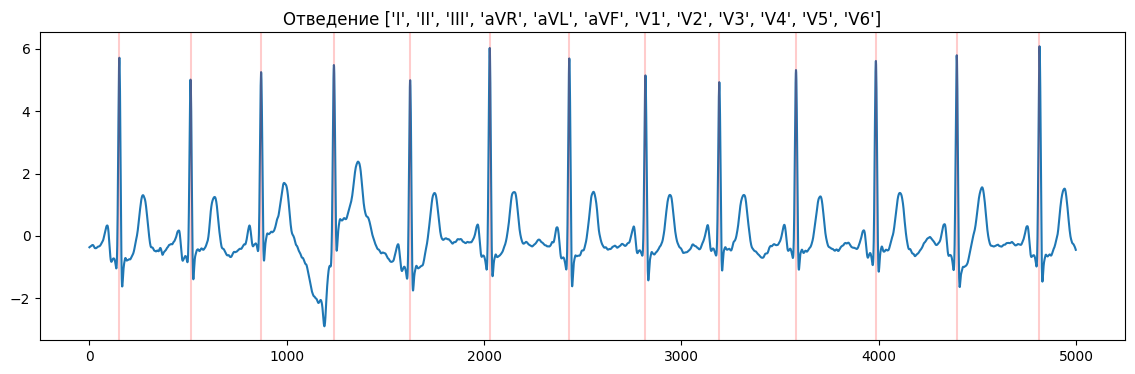

35 1 402.92857142857144 4.832394935880814 23.352040816326532


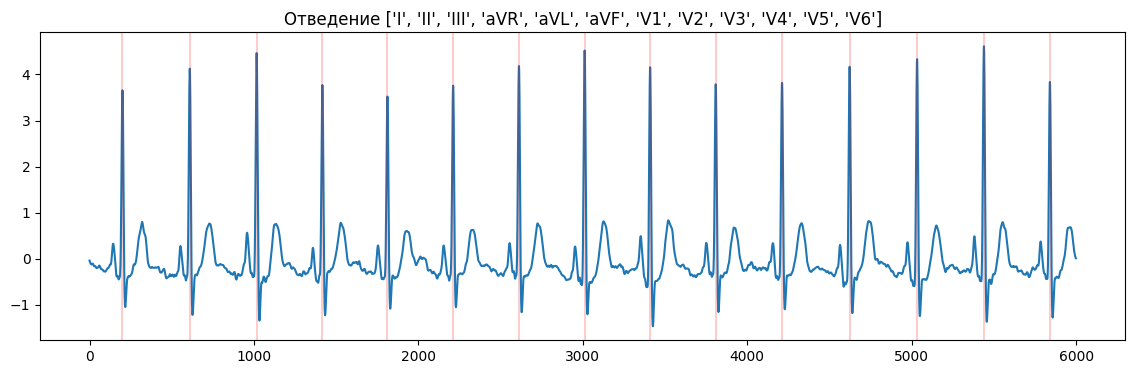

36 22;23 565.375 31.340618612273754 982.234375


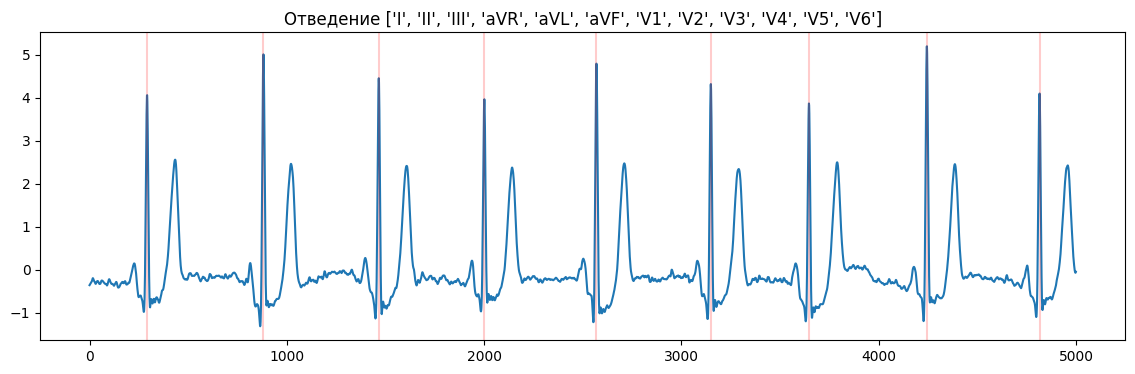

37 22 663.2857142857143 23.86697829766526 569.6326530612245


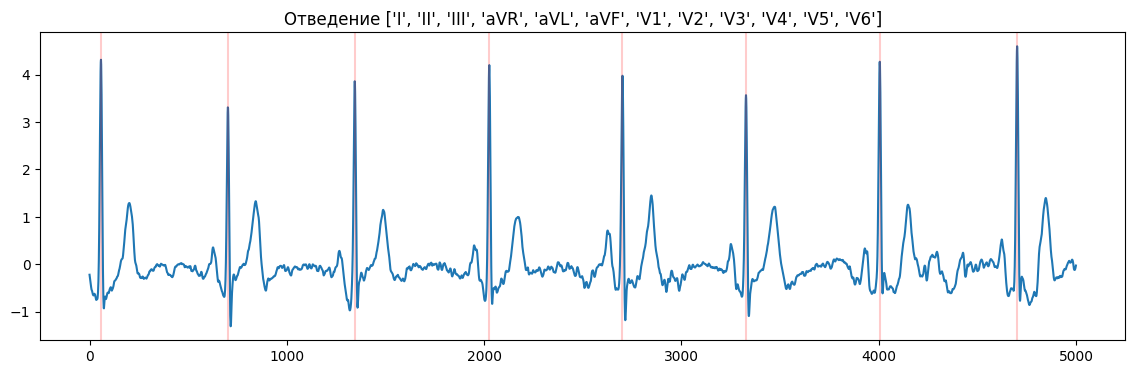

38 22;145 509.9 11.631422956801115 135.29


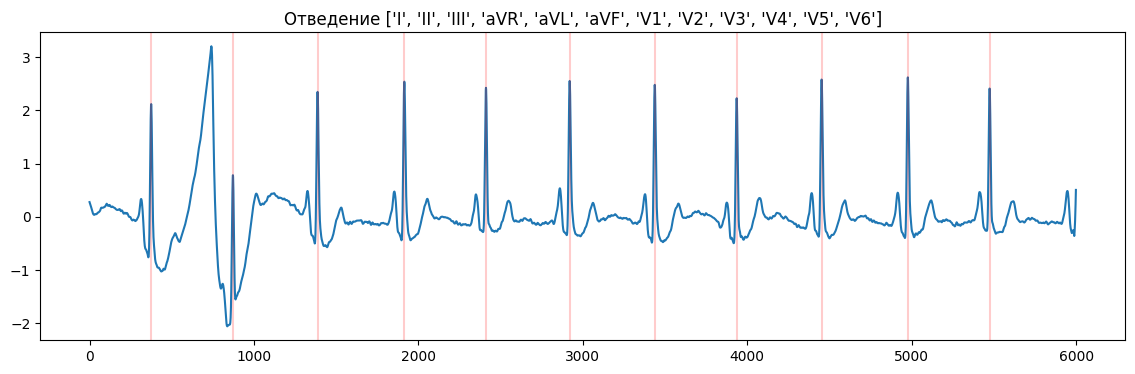

39 1 437.1 24.768730286391346 613.49


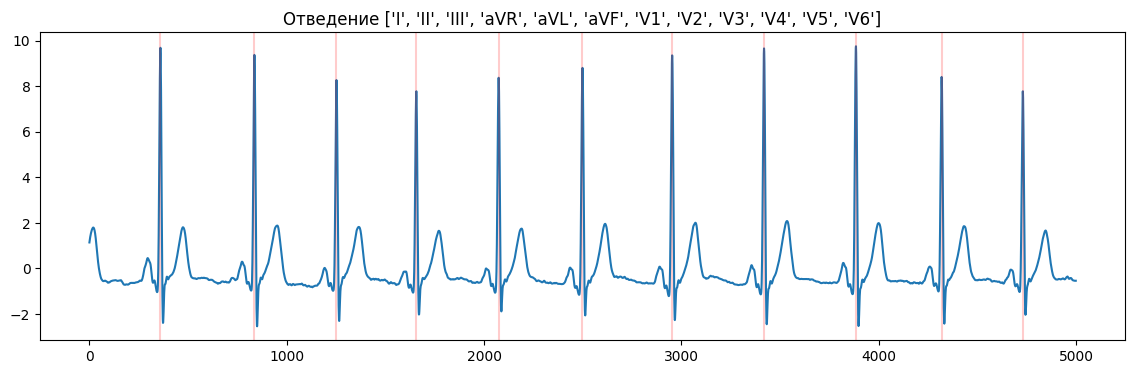

40 22;23 523.1111111111111 51.66439660484974 2669.2098765432097


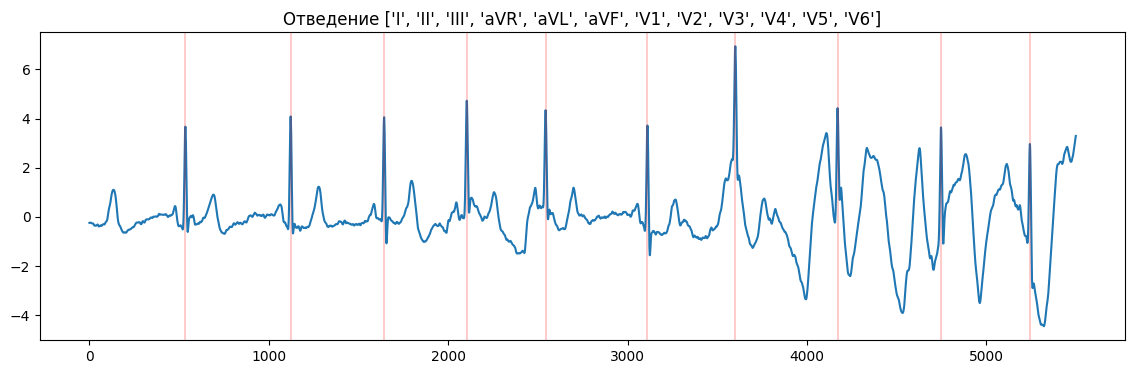

41 1 431.90909090909093 23.769554803091918 564.99173553719


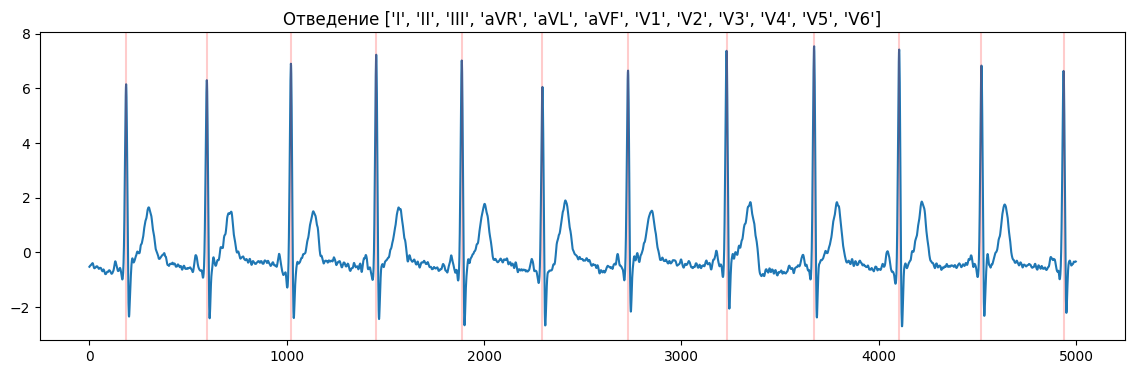

42 147 301.73333333333335 6.43393779543722 41.39555555555556


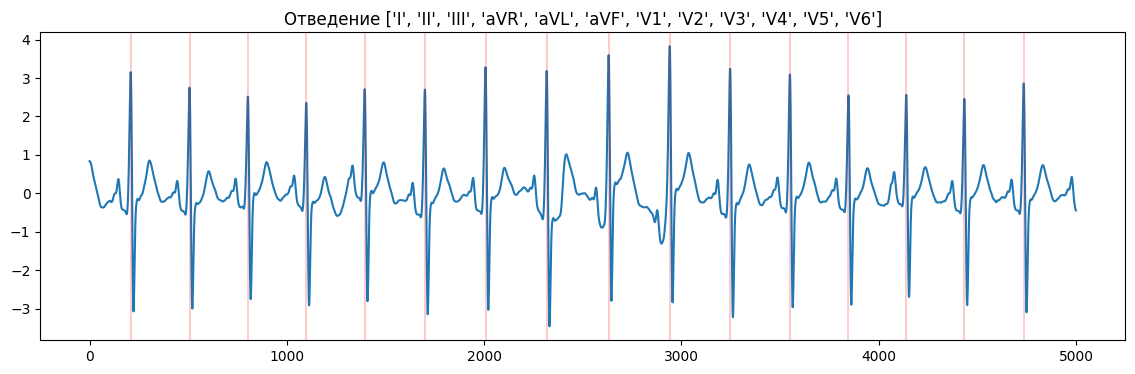

43 1 376.3333333333333 6.835365551469959 46.72222222222222


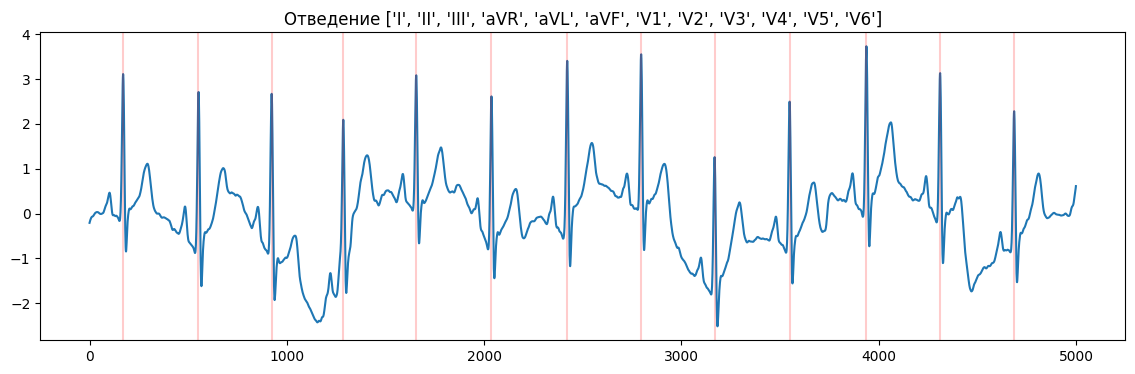

44 22 542.5 9.069178573608527 82.25


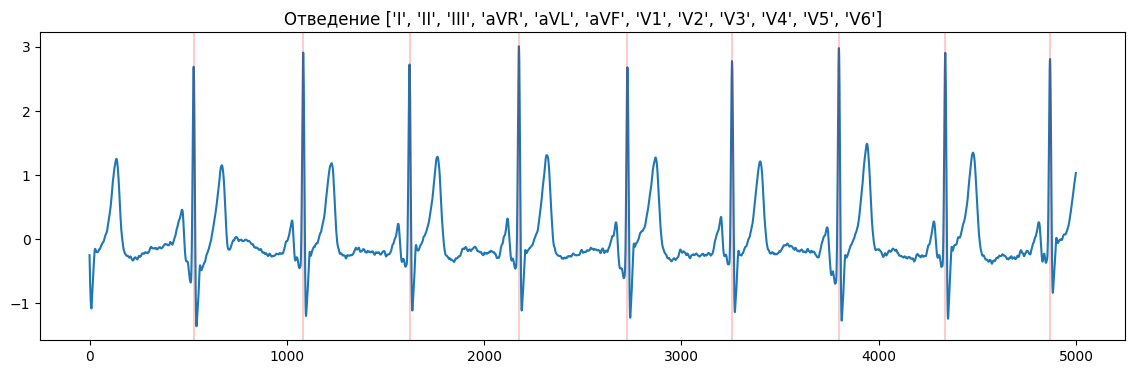

45 1 313.8 1.5577761927397231 2.426666666666667


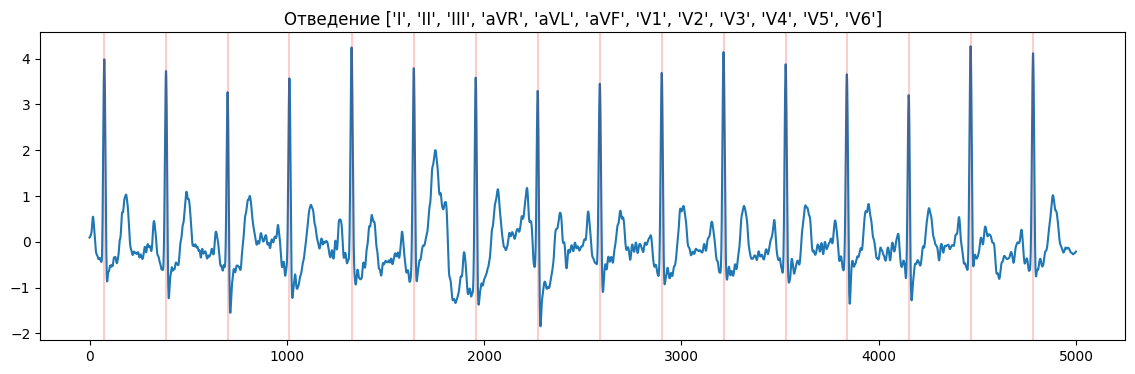

46 1 425.53846153846155 8.661278859342305 75.01775147928994


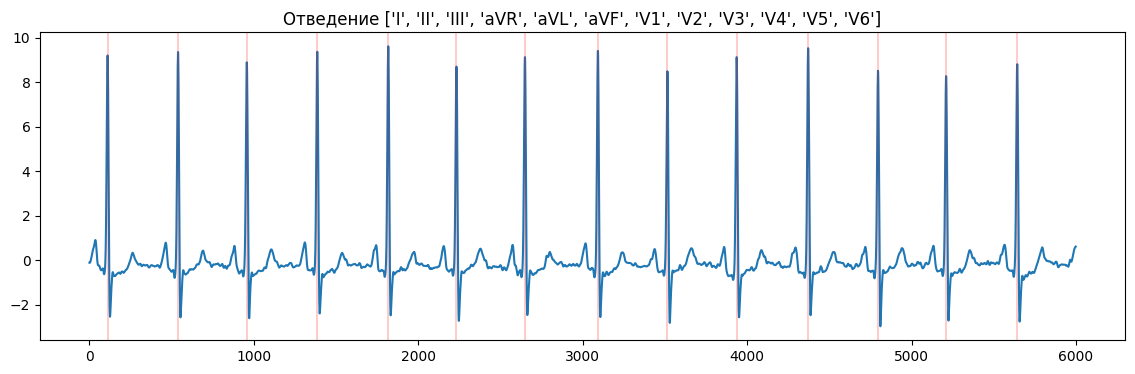

47 1 466.9 13.163965967746954 173.29


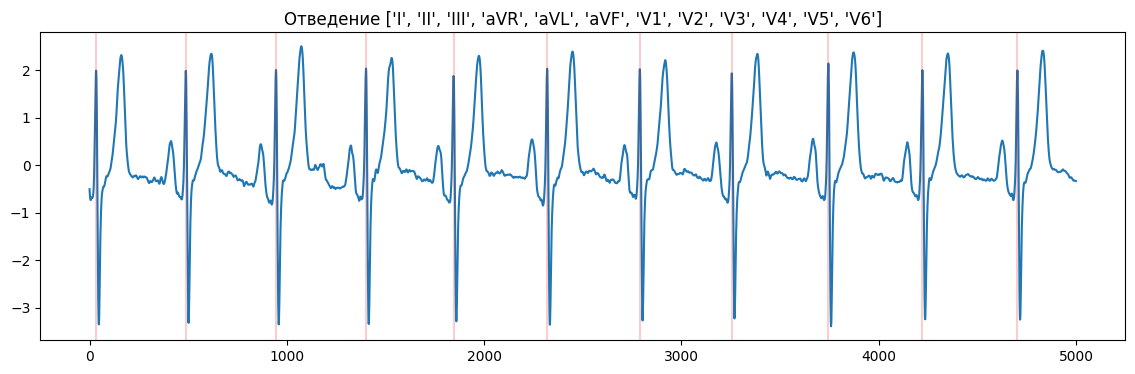

48 147 405.7857142857143 16.768075839133683 281.16836734693874


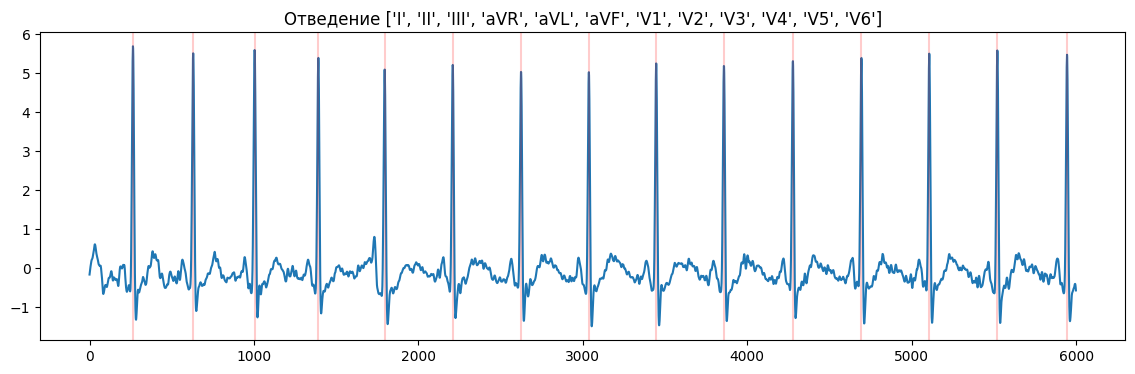

49 1 470.5 7.952986860293433 63.25


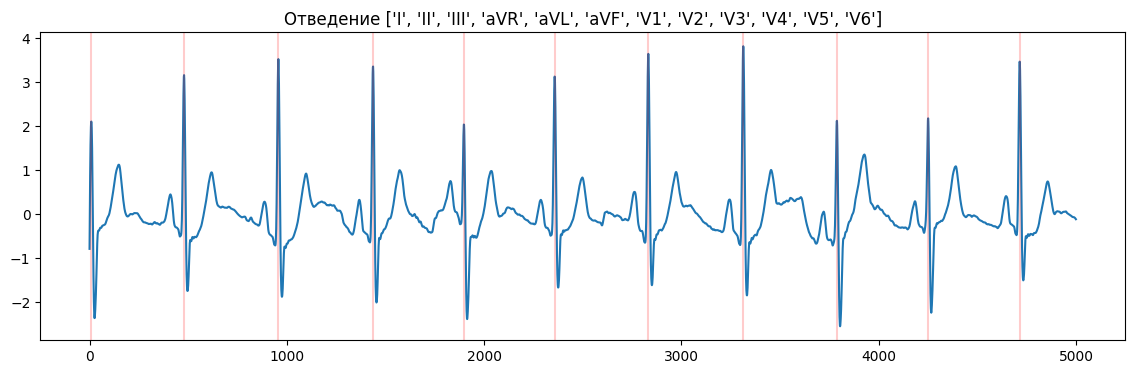

50 1 479.6666666666667 16.08311744241976 258.6666666666667


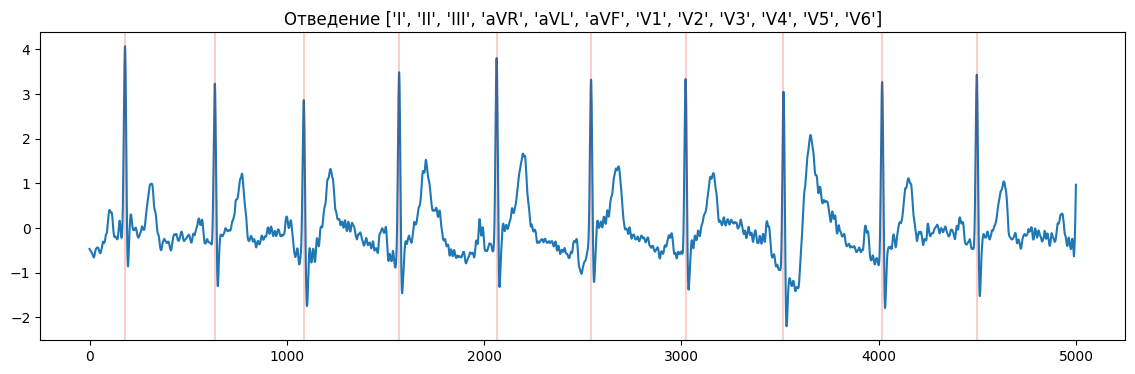

51 125 317.06666666666666 6.475252032846973 41.928888888888864


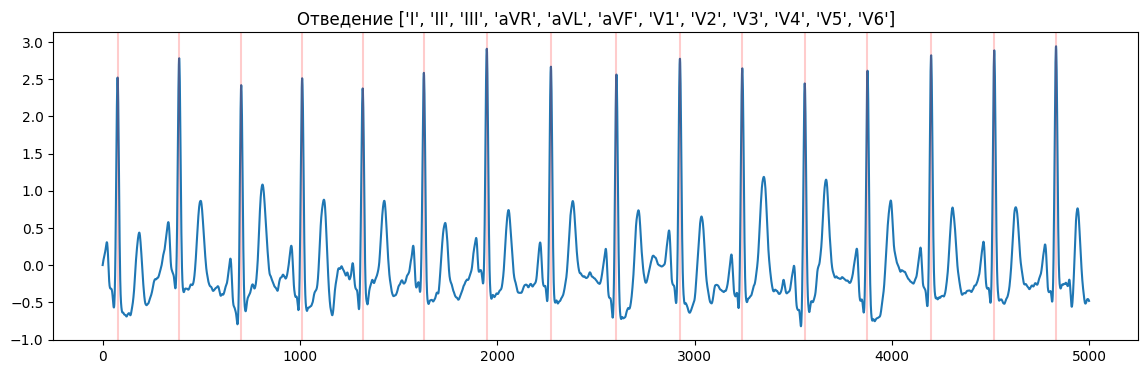

52 1 323.70588235294116 3.024696501689986 9.14878892733564


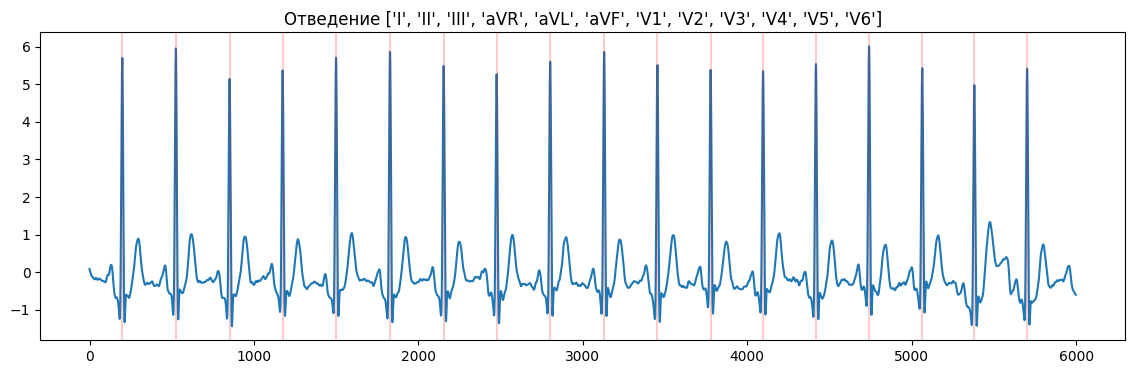

53 22 572.7142857142857 18.55273784735431 344.2040816326531


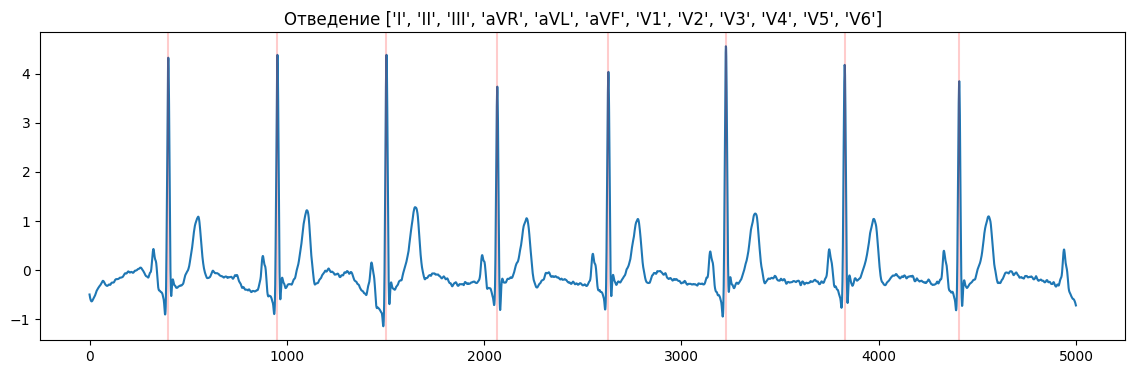

54 22;145+362 533.1111111111111 17.502028101175046 306.320987654321


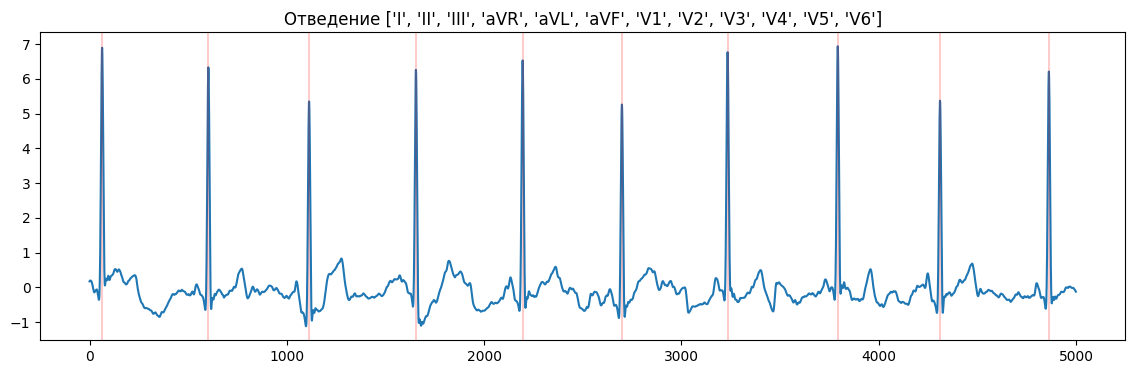

55 1 406.8181818181818 11.991043489494238 143.78512396694217


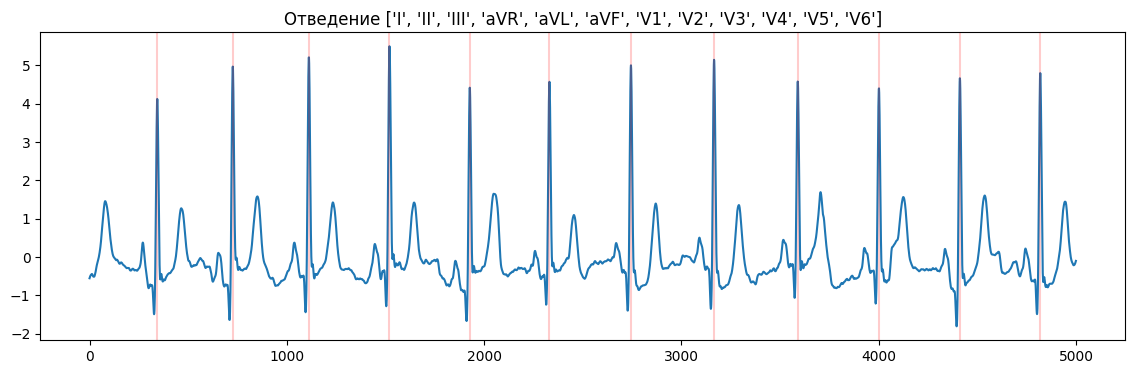

56 1 453.0833333333333 10.688454310870004 114.24305555555556


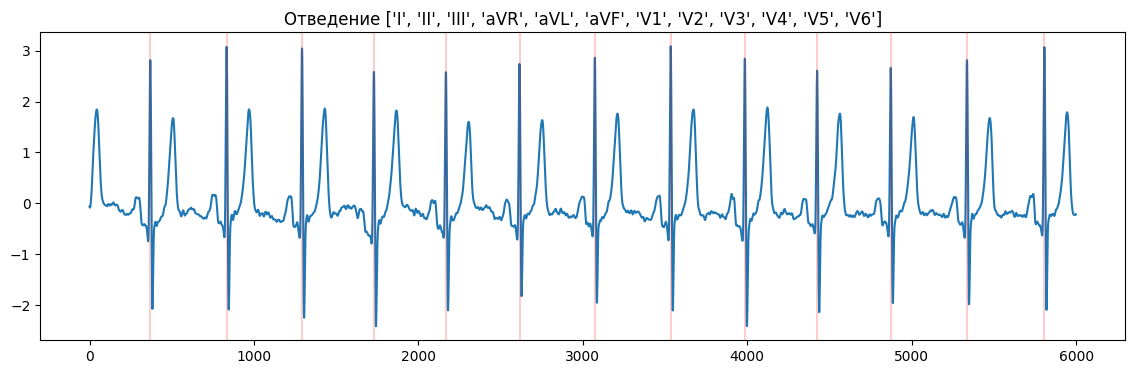

57 1 324.26666666666665 6.506065546003121 42.32888888888889


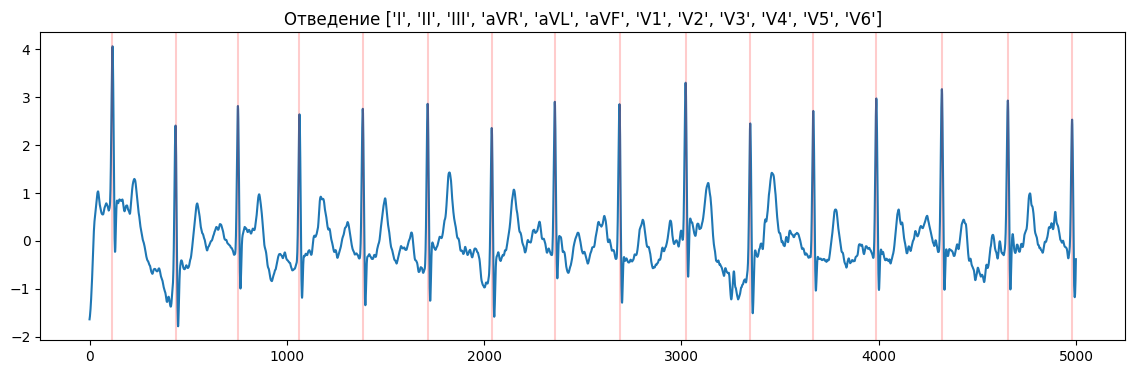

58 120 426.6363636363636 4.538175990672249 20.59504132231405


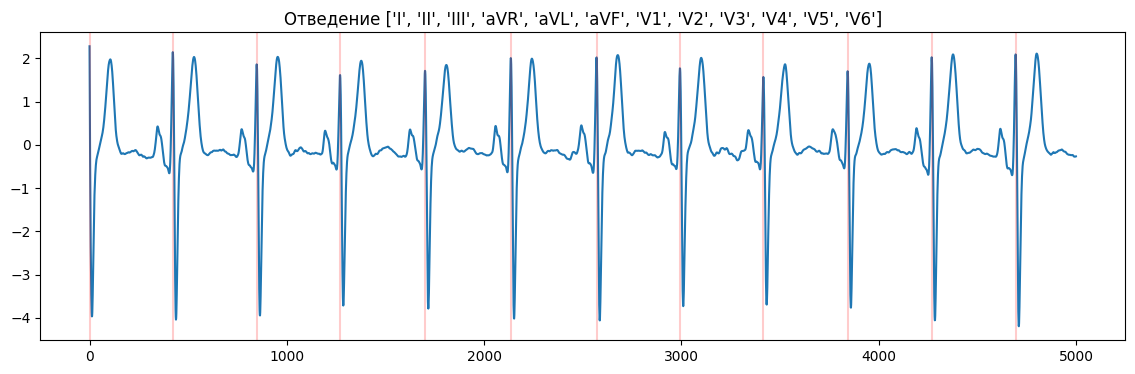

59 1 341.11764705882354 10.34625452513913 107.04498269896193


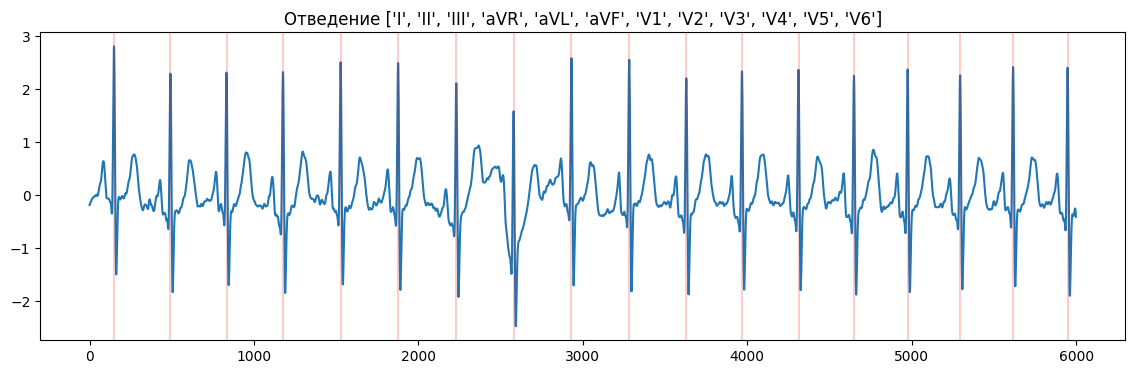

60 1 459.9 2.2113344387495983 4.890000000000001


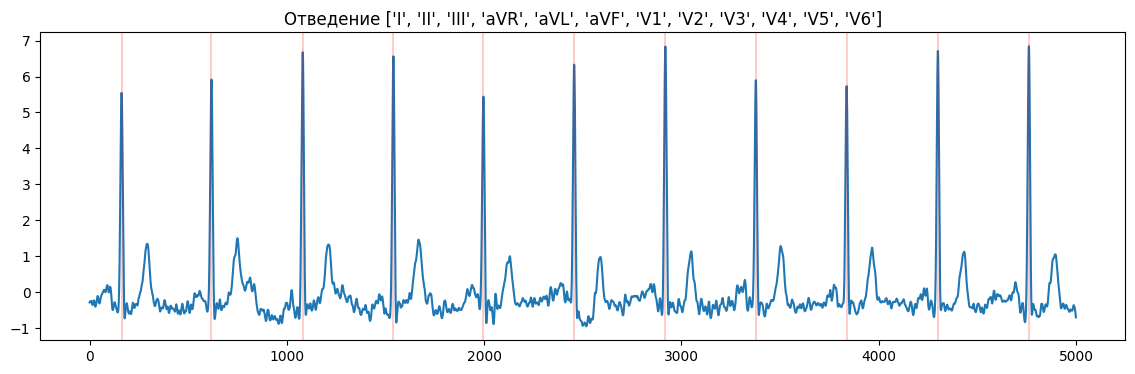

61 1 367.53846153846155 14.990332190168358 224.71005917159766


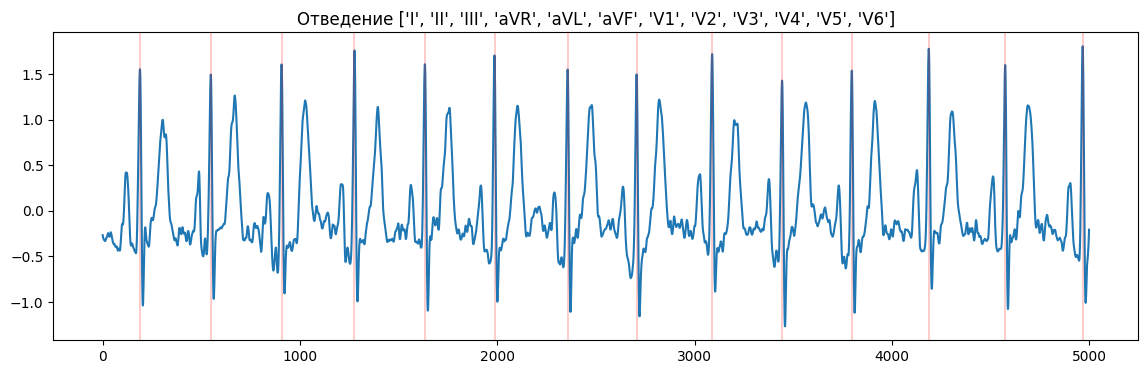

62 1 486.0 6.9602043392737 48.44444444444444


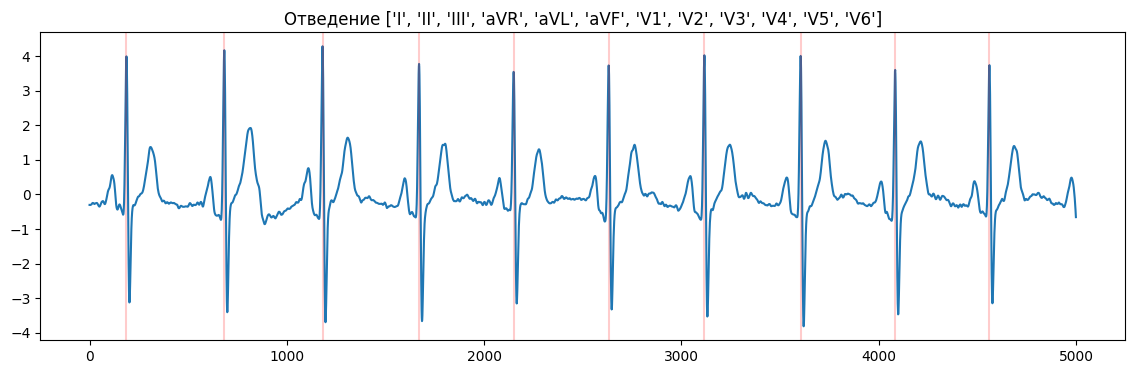

63 22 514.125 16.929541488179765 286.609375


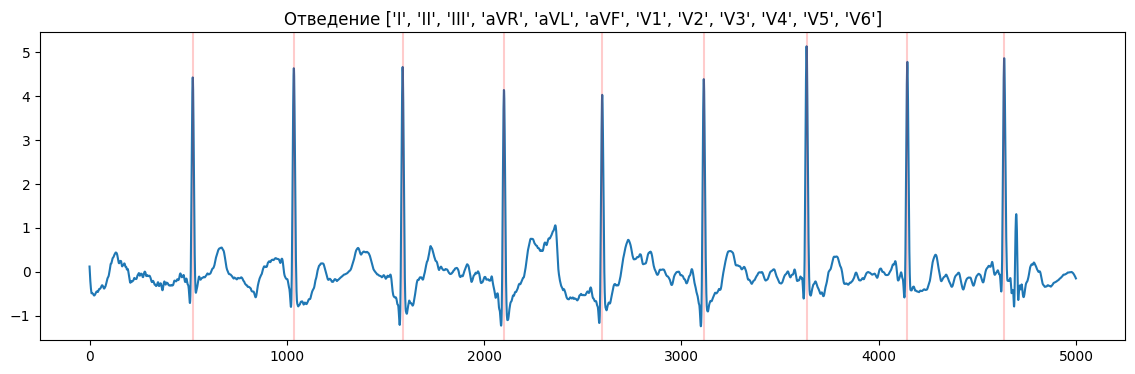

64 105 358.2307692307692 13.717780971895543 188.17751479289942


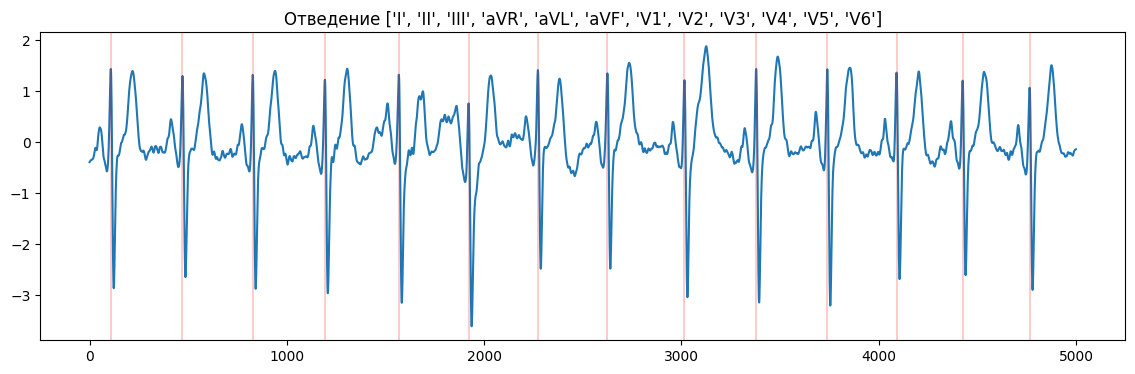

65 1 387.61538461538464 1.9821690348807885 3.9289940828402363


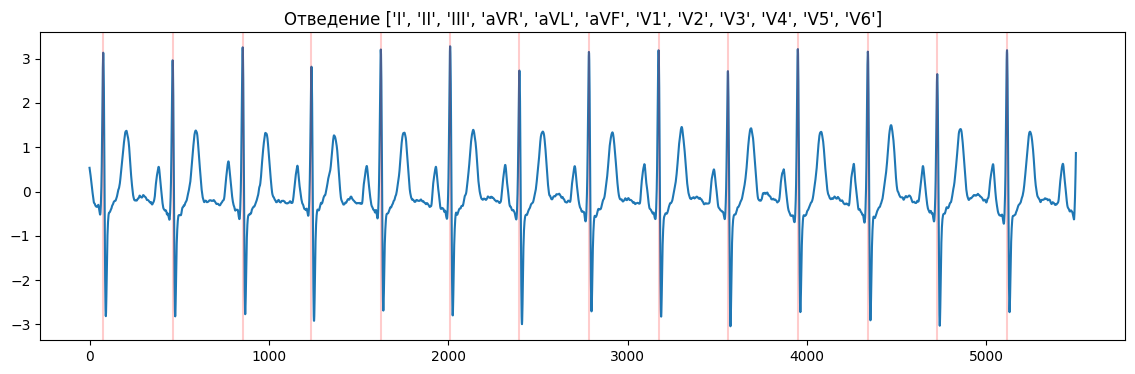

66 1 404.90909090909093 6.374017506530219 40.628099173553714


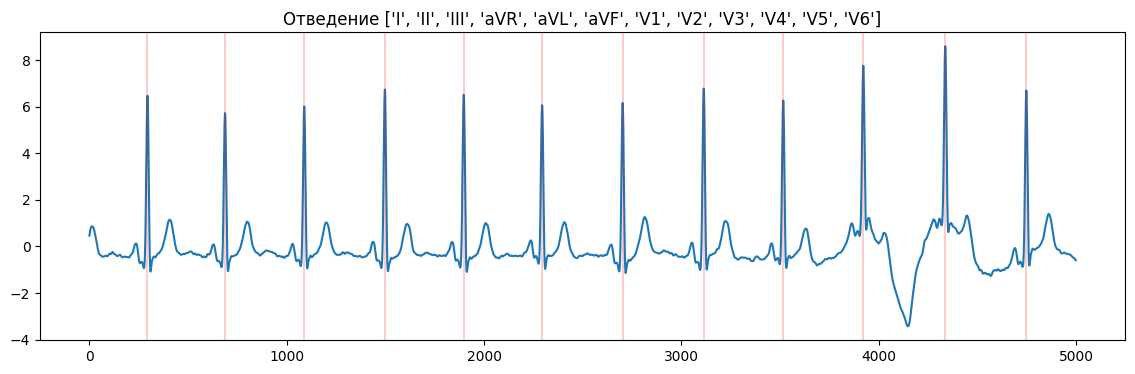

67 155 417.1818181818182 6.873112062340291 47.23966942148761


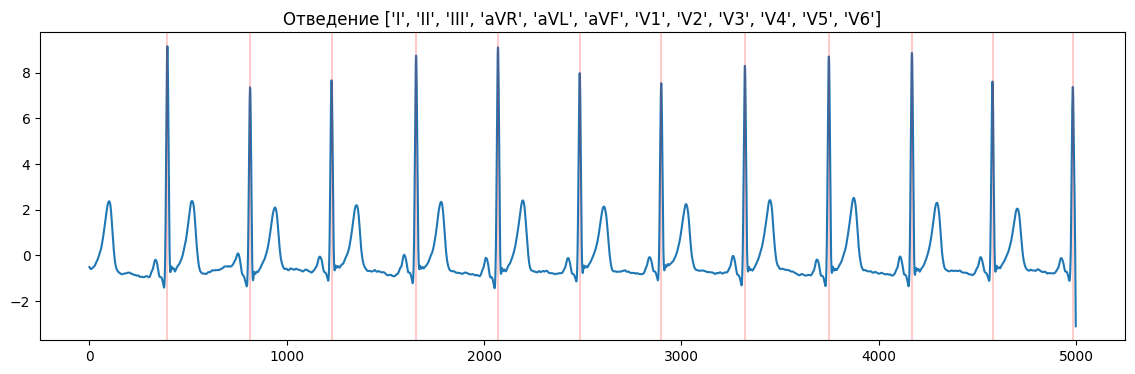

68 1 417.3636363636364 11.80348736812925 139.3223140495868


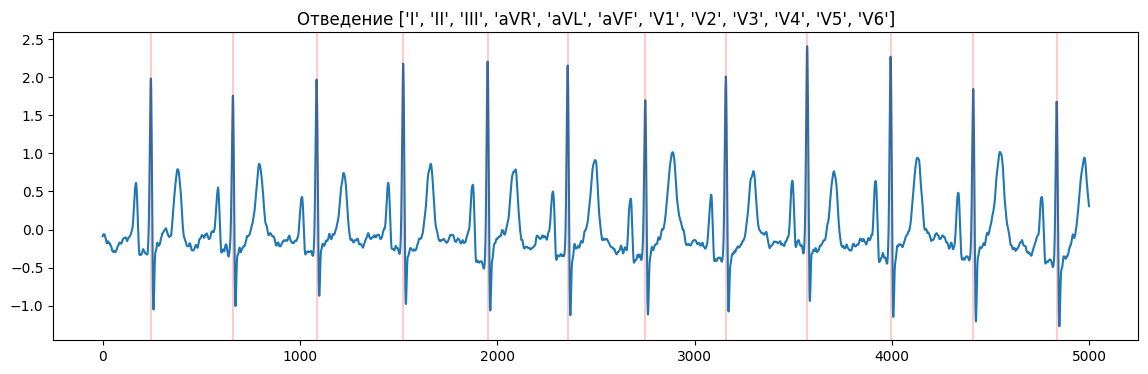

69 1 442.0 6.276941930590086 39.4


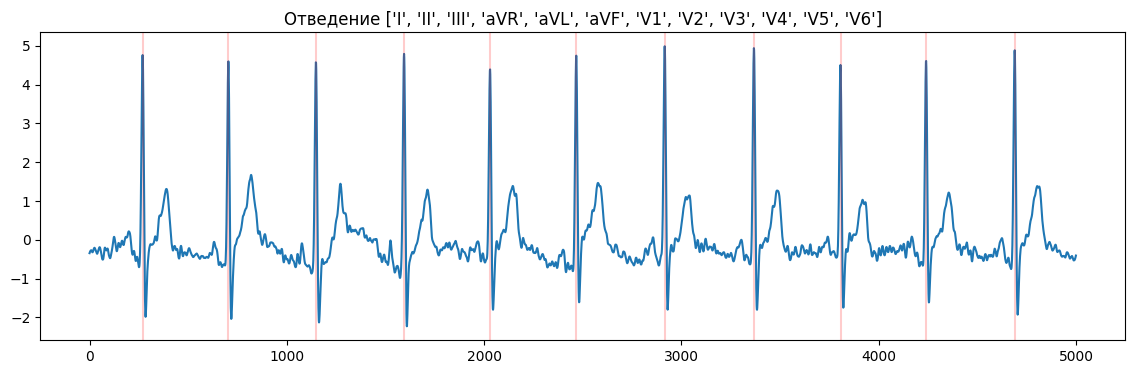

70 145+362 413.1818181818182 13.421950690215581 180.1487603305785


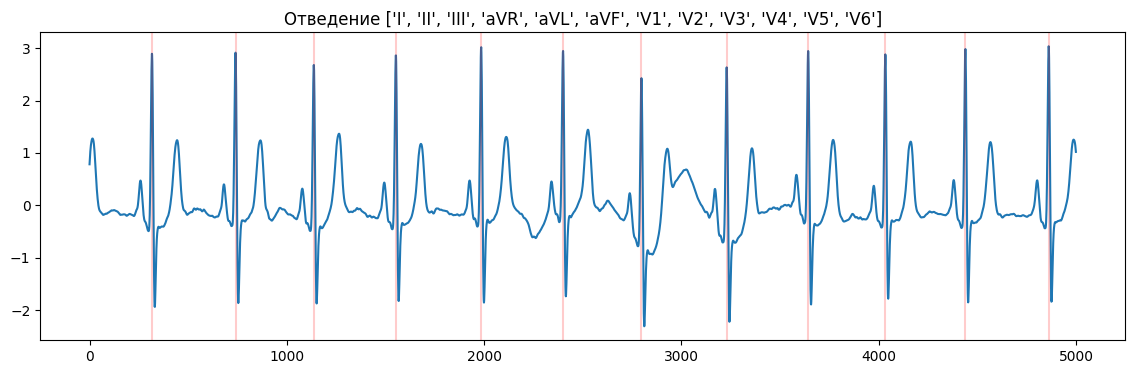

71 1 369.06666666666666 7.113055289786206 50.59555555555553


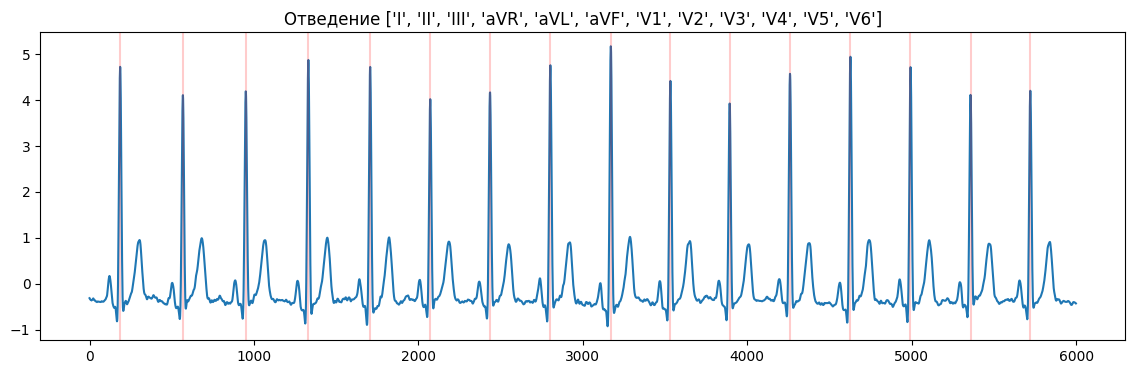

In [85]:
for idx, i, mean, std, var in zip(range(len(idx_code)), idx_code, means, stds, vars):
    print(idx, i, mean, std, var)
    visualize_channel_with_peaks(signals_transformed, r_peaks_all, idx)

In [165]:
k = 290
meansK = means[0:k]
stdsK = stds[0:k]
varsK = vars[0:k]
yK = labels_transformed[0:k]

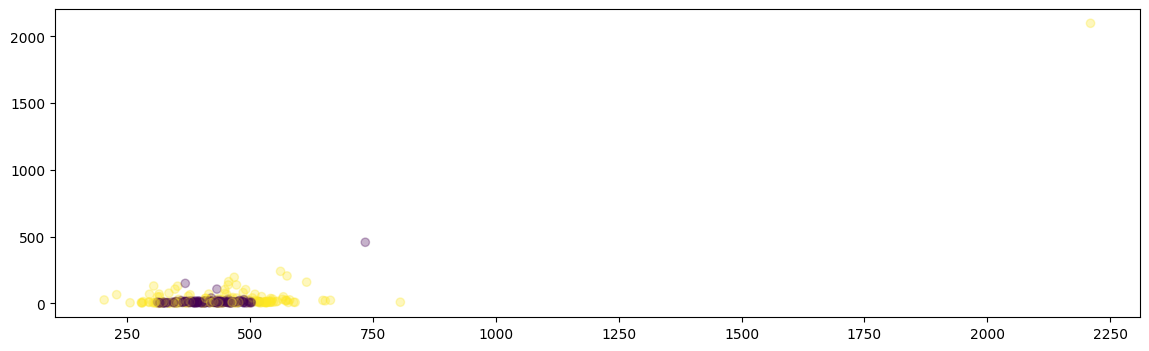

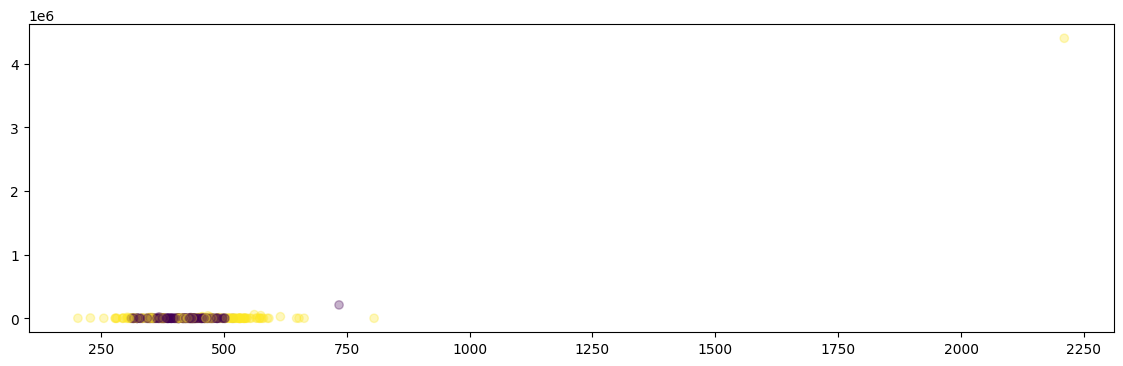

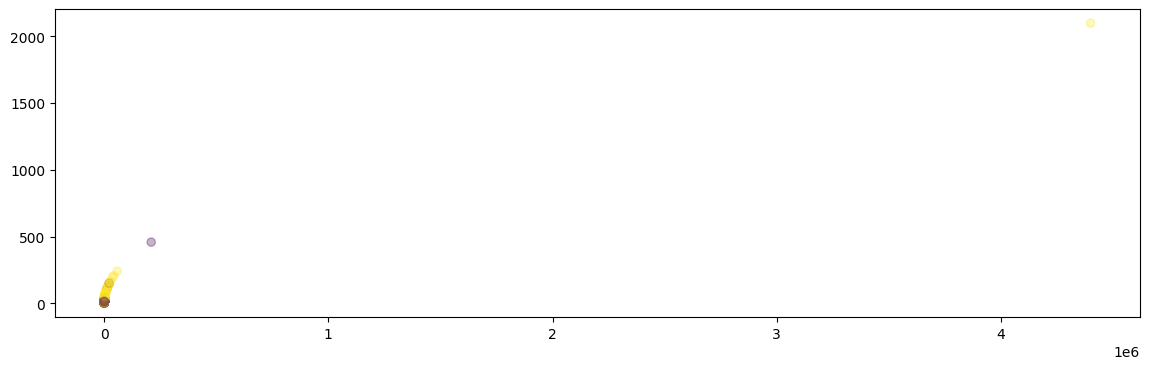

In [166]:
plt.scatter(meansK, stdsK, c=labels_transformed[0:k], alpha=0.3)
plt.show()
plt.scatter(meansK, varsK, c=labels_transformed[0:k], alpha=0.3)
plt.show()
plt.scatter(varsK, stdsK, c=labels_transformed[0:k], alpha=0.3)
plt.show()

In [150]:
def bayes(a_, b_, y_data_):
    y_data_ = y_data_.flatten()
    a = []
    b = []
    y_data = []
    for i in range(len(a_)):
        if not np.isnan(a_[i]) and not np.isnan(b_[i]):
            a.append(a_[i])
            b.append(b_[i])
            y_data.append(y_data_[i])

    nd_embed = np.transpose([a, b])
    model_nb = GaussianNB()
    calibrated_model = CalibratedClassifierCV(model_nb, method='isotonic', cv=5)
    calibrated_model.fit(nd_embed, y_data)
    
    # Получение вероятностей и предсказаний
    probabilities = calibrated_model.predict_proba(nd_embed)
    max_probabilities = np.max(probabilities, axis=1)
    preds = calibrated_model.predict(nd_embed)
    
    # Расчет метрик
    print(f"Accuracy: {accuracy_score(y_data, preds):.2f}")
    print(f"F1-score: {f1_score(y_data, preds, average='weighted'):.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_data, preds))
    
    # Правый график (вероятности)
    plt.scatter(
        a,
        b,
        c=max_probabilities,
        cmap="viridis",
        alpha=0.2,
        vmin=0,
        vmax=1
    )
    plt.show()

Accuracy: 0.73
F1-score: 0.71
Confusion Matrix:
[[1470  135]
 [ 682  688]]


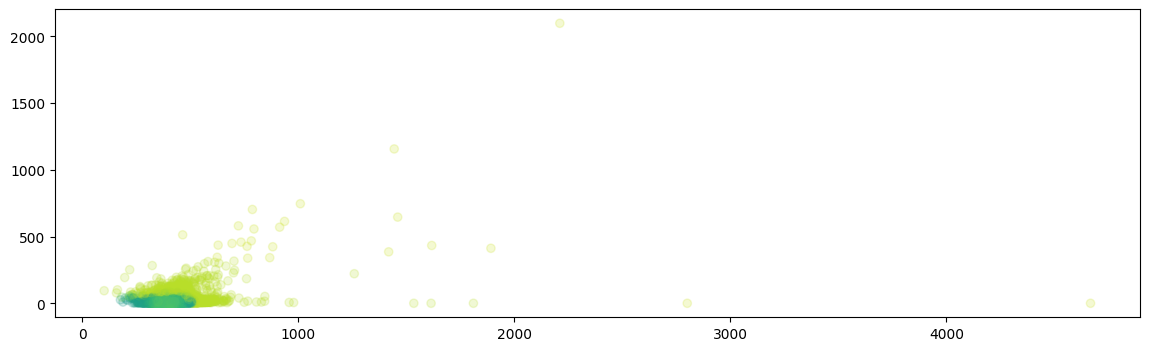

Accuracy: 0.68
F1-score: 0.65
Confusion Matrix:
[[1527   78]
 [ 875  495]]


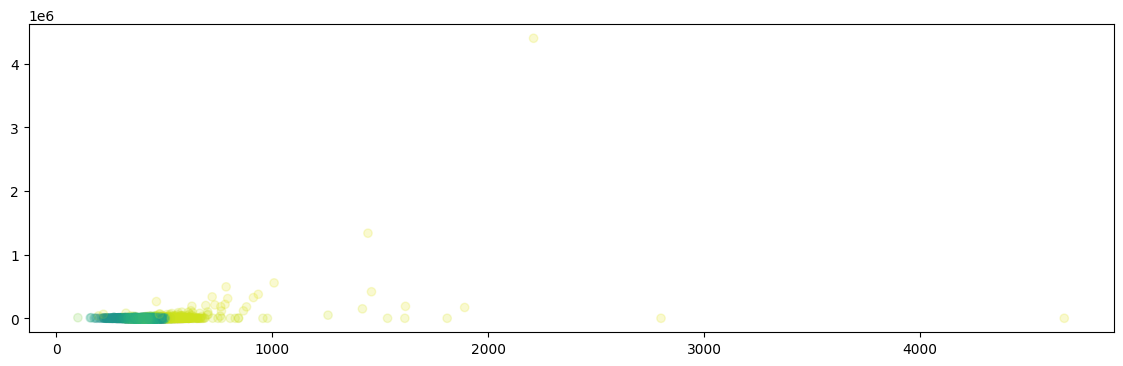

Accuracy: 0.66
F1-score: 0.64
Confusion Matrix:
[[1431  174]
 [ 826  544]]


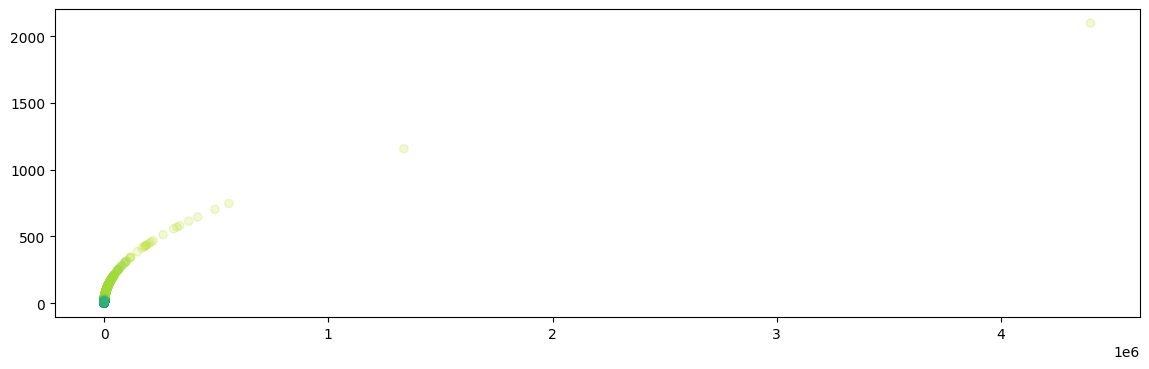

In [152]:
bayes(meansK, stdsK, yK)
bayes(meansK, varsK, yK)
bayes(varsK, stdsK, yK)

In [177]:
for i in range(len(meansK)):
    if np.isnan(meansK[i]) or np.isnan(stdsK[i]):
        print(i)

124
162


In [174]:
r_peaks_all = find_R_peaks(signals_transformed)

In [183]:
r_peaks_all_delta = []
means = []
stds = []
vars = []

for r_peaks in r_peaks_all:
    r_peaks_delta = []
    for j in range(len(r_peaks) - 1):
        r_peaks_delta.append(r_peaks[j + 1] - r_peaks[j])
    r_peaks_all_delta.append(r_peaks_delta)
    
    means.append(np.mean(r_peaks_delta))
    stds.append(np.std(r_peaks_delta))
    vars.append(np.var(r_peaks_delta))

In [184]:
ns = []

for i in range(len(r_peaks_all)):
    ns.append(len(r_peaks_all[i]))

ns = np.unique(ns)

In [185]:
ns

array([ 6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 28, 32, 34, 37])

In [189]:
for i in range(len(r_peaks_all)):
    if len(r_peaks_all[i]) == 34:
        print(i)

84


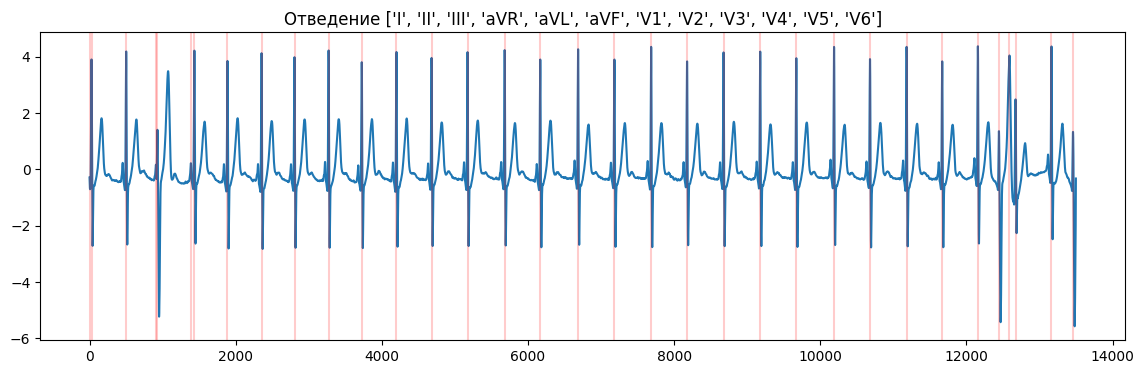

In [190]:
visualize_channel_with_peaks(signals_transformed, r_peaks_all, 84, 0)